# Colocalization between placental mQTL, psychiatric and developmental traits

Idea: for all heritable CpGs, test for colocalization between traits and GWAS summary statistics for conditions where a significant proportion of heritability can be explained by placental mQTL.
Traits to include:
* Neuropsychiatric
    1. OCD
    1. TS
    1. ADHD
    1. ASD
    1. MDD
    1. BIP
    1. AN
    1. SCZ
* Developmental: 
    1. Pubertal Growth Start
    1. Asthma
    1. Child BMI
    1. Child Onset Asthma

In [1]:
library(tidyverse)
library(data.table)
library(coloc)
# library(bigsnpr)
library(here)
library(parallel)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [2]:
if (file.exists(here("data","marginal_mcpg_bonf.txt.gz"))){
    marginal_bonf <- fread(here("data","marginal_mcpg_bonf.txt.gz"),key="SNP")
}else{
    marginal <- fread(here("data","delahaye_richs_marginal_mecs_maf01.txt.gz"))
    marginal_bonf <- fread(here("data","delahaye_richs_marginal_bonf_maf05.txt.gz"))[Chr != 23]
    marginal_bonf <- marginal[Probe %in%marginal_bonf$Probe]
    fwrite(marginal_bonf,here("data","marginal_mcpg_bonf.txt.gz"),row.names=F,quote=F,sep='\t')
}

In [3]:
rds < -snp_readBed2(
    "/arc/project/st-dennisjk-1/shared/data/1000G_EUR_ldsc_data/1000G_EUR_Phase3_plink/1000G.EUR.QC.ALL.bed",
    backingfile=tempfile(),
)

In [ ]:
reference < -snp_attach(rds)

In [5]:
str(reference)

List of 3
 $ genotypes:Reference class 'FBM.code256' [package "bigstatsr"] with 16 fields
  ..$ extptr      :<externalptr> 
  ..$ extptr_rw   :<externalptr> 
  ..$ nrow        : int 489
  ..$ ncol        : int 9997231
  ..$ type        : Named int 1
  .. ..- attr(*, "names")= chr "unsigned char"
  ..$ backingfile : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.bk"
  ..$ is_read_only: logi FALSE
  ..$ address     :<externalptr> 
  ..$ address_rw  :<externalptr> 
  ..$ bk          : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.bk"
  ..$ rds         : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.rds"
  ..$ is_saved    : logi TRUE
  ..$ type_chr    : chr "unsigned char"
  ..$ type_size   : int 1
  ..$ file_size   : num 4.89e+09
  ..$ code256     : num [1:256] 0 1 2 NA NA NA NA NA NA NA ...
  ..and 26 methods, of which 12 are  possibly relevant:
  ..  add_columns, as.FBM, bm, bm.desc, check_dimensions,
  ..  check_write_permis

In [ ]:
compute_coloc <- function(SNP,mqtl,gwas,method="coloc", type="quant",s=NULL){# SNP must be in SNP column of mqtl and gwas
    D1 <- list(
            beta = mqtl$b,
            varbeta = mqtl$SE^2,
            snp = mqtl$SNP,
            position = mqtl$BP,
            N = 400,
            MAF = mqtl$Freq,
            type="quant"
        )
    D2 <- list(
            pvalues = pnorm(-abs(gwas$Z))*2,
            z=gwas$Z,
            snp = gwas$SNP,
            MAF = snp_MAF(reference$genotypes,ind.col = match(gwas$SNP,reference$map$marker.ID)),
            N = min(gwas$N),
            type=type,
            s = s
        )
    if(method == "susie"){
        LD <- snp_cor(reference$genotypes,ind.col = match(SNP, reference$map$marker.ID))^2
        LD <- as.matrix(LD)
        colnames(LD) <- SNP
        rownames(LD) <- SNP
        D1$LD <- LD
        D2$LD <- LD
        S1 <- runsusie(D1)
        S2 <- runsusie(D2)
        return(coloc.susie(S1,S2))
    }else if(method == "coloc"){
        return(coloc.abf(D1,D2))
    }else{
        return(NULL)
    }
}

In [14]:
gwas <- fread("../../tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",key="SNP")

tmp_marginal_bonf <- marginal_bonf[intersect(gwas$SNP,reference$map$marker.ID),on="SNP",nomatch=0]

eligible_cpg <- unlist(mclapply(
    unique(tmp_marginal_bonf$Probe),
    function(probe){
        mqtl <- tmp_marginal_bonf[Probe == probe]
        gwas_tmp <- gwas[mqtl$SNP,on="SNP"]
        return(min(mqtl$p) < 5e-8 & max(abs(gwas_tmp$Z)) > 5.45 )
    },
    mc.cores=16
))
test <- mclapply(
    unique(marginal_bonf$Probe)[eligible_cpg],
    function(probe){
        mqtl <- tmp_marginal_bonf[Probe == probe]
        gwas_tmp <- gwas[SNP %in% mqtl$SNP]
        res <- suppressMessages(compute_coloc(mqtl$SNP,mqtl,gwas_tmp,method="coloc",s=0.36,type="cc")$summary)
        return(res)
    },
    mc.cores=16
)

names(test) <- unique(marginal_bonf$Probe)[eligible_cpg]
result_adhd <- rbindlist(lapply(test,function(x)data.table(t(x))))
result_adhd

# Repeating above for all psychiatric GWAS

In [3]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/anxiety.meta.full.fs.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/anxiety.meta.full.cc.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgcAN2.2019-07_refmt.vcf.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/AUDIT_UKB_2018_AJP_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/Cannabis_ICC_23andmetop_UKB_het_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/iPSYCH-PGC_ASD_Nov2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/ocd_aug2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgc_alcdep.eur_unrelated.aug2018_release_refmt.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgc_bip_2018.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC_UKB_depression_genome-wide_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/MDD2018_ex23andMe.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC3_SCZ_wave3_public.v2.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/tag.cpd.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/TS_Oct2018.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pts_all_freeze2_overall.results.sumstats.gz",
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    0.36,
    NULL,
    0.33,
    0.23,
    NULL,
    0.30,
    0.40,
    0.28,
    0.26,
    0.15,
    0.34,
    0.35,
    0.42,
    NULL,
    0.34,
    0.15,
)

ERROR: Error in eval(expr, envir, enclos): object 'sumstat_files' not found


In [ ]:
result <- list()
for( i in 1:length(sumstat_files)){
    gwas <- fread(sumstat_files[i])
    tmp_marginal_bonf <- marginal_bonf[intersect(gwas$SNP,reference$map$marker.ID),on="SNP",nomatch=0]
    eligible_cpg <- unlist(mclapply(
        unique(tmp_marginal_bonf$Probe),
        function(probe){
            mqtl <- tmp_marginal_bonf[Probe == probe]
            gwas_tmp <- gwas[mqtl$SNP,on="SNP"]
            return(min(mqtl$p) < 5e-8 & max(abs(gwas_tmp$Z)) > 5.45 )
        },
        mc.cores=16
    ))
    if(sum(eligible_cpg) ){
        test <- mclapply(
            unique(tmp_marginal_bonf$Probe)[eligible_cpg],
            function(probe){
                mqtl <- tmp_marginal_bonf[Probe == probe]
                gwas_tmp <- gwas[SNP %in% mqtl$SNP]
                res <- suppressMessages(
                    compute_coloc(
                        mqtl$SNP,
                        mqtl,
                        gwas_tmp,
                        method="coloc",
                        s=sample_prev[i],
                        type=ifelse(is.null(sample_prev[i]),"quant","cc")
                    )$summary
                )
                return(res)
            },
            mc.cores=16
        )
        names(test) <- unique(tmp_marginal_bonf$Probe)[eligible_cpg]
        res <- rbindlist(lapply(test,function(x)data.table(t(x))))
        result[[trait_names[i]]] <- res
    }
}

In [64]:
str(result)

 list()


# Neonatal Traits

In [ ]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PGF_PGM_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_Obesity_Meta_Analysis_1.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG-TotalGWG-Offspring.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PTF_PTM_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_asthma_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_BMI_HapMap_DISCOVERY.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_10F_12M_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_HC_DISCOVERY.v2.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC.sumstats.gz",
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, 0.0296
)

## Summary of all trait colocalization

In [16]:
trait_coloc <- dir(here("data"),pattern= ".*_colocalization.txt",full.names = TRUE)
sex_trait_coloc <- dir(here("data"),pattern= ".*mqtlcolocalization.txt",full.names = TRUE)
all_coloc <- lapply(trait_coloc,fread)
sex_stratified_coloc <- lapply(sex_trait_coloc,fread)
names(all_coloc) <- gsub(".*/(.*)_colocalization.txt","\\1",trait_coloc)
names(sex_stratified_coloc) <- gsub(".*/(.*)_mqtlcolocalization.txt","\\1",sex_trait_coloc)
coloc_table <- rbindlist(all_coloc,idcol="GWAS")
sex_coloc_table <- rbindlist(sex_stratified_coloc,idcol="GWAS")

In [20]:
#sex_coloc_table[grepl("ECZEMA.*",GWAS)]
coloc_table[grepl("ecz",GWAS,ignore.case = T)]

GWAS,probe,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


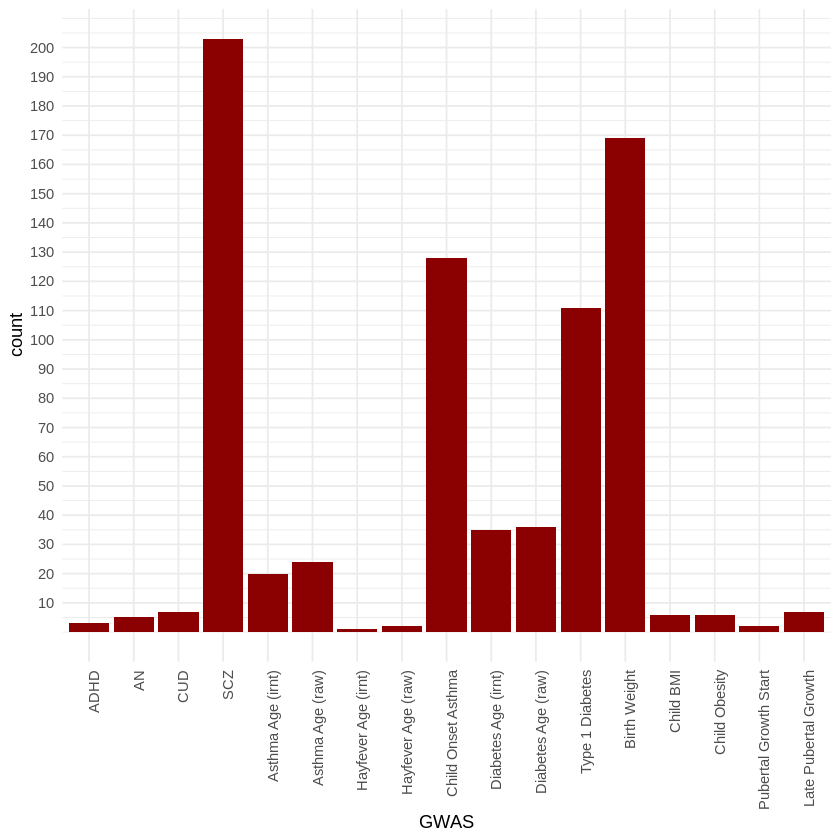

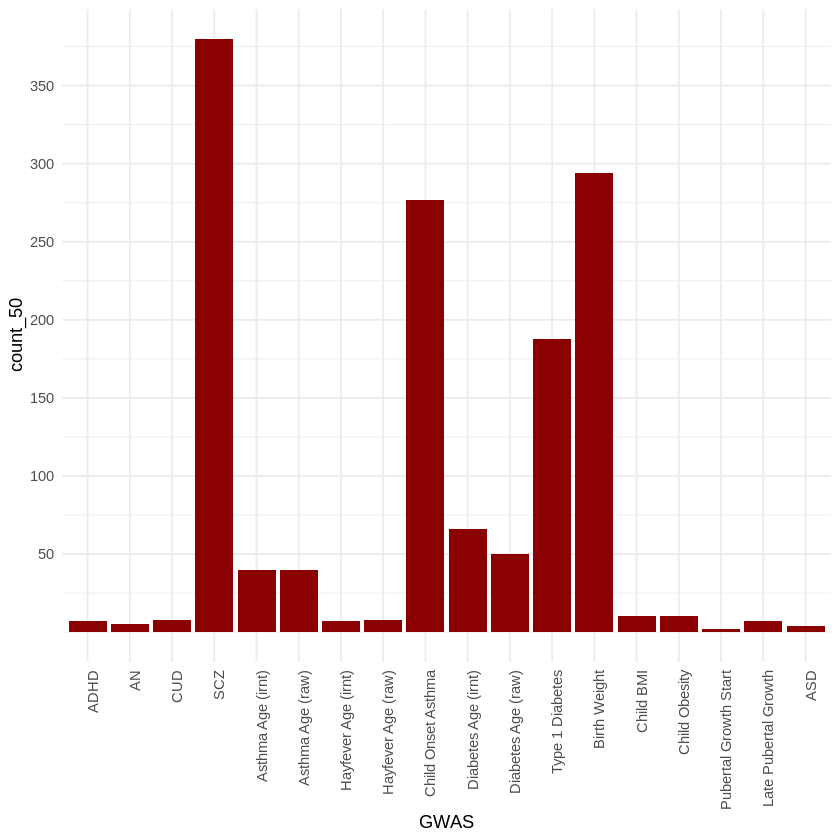

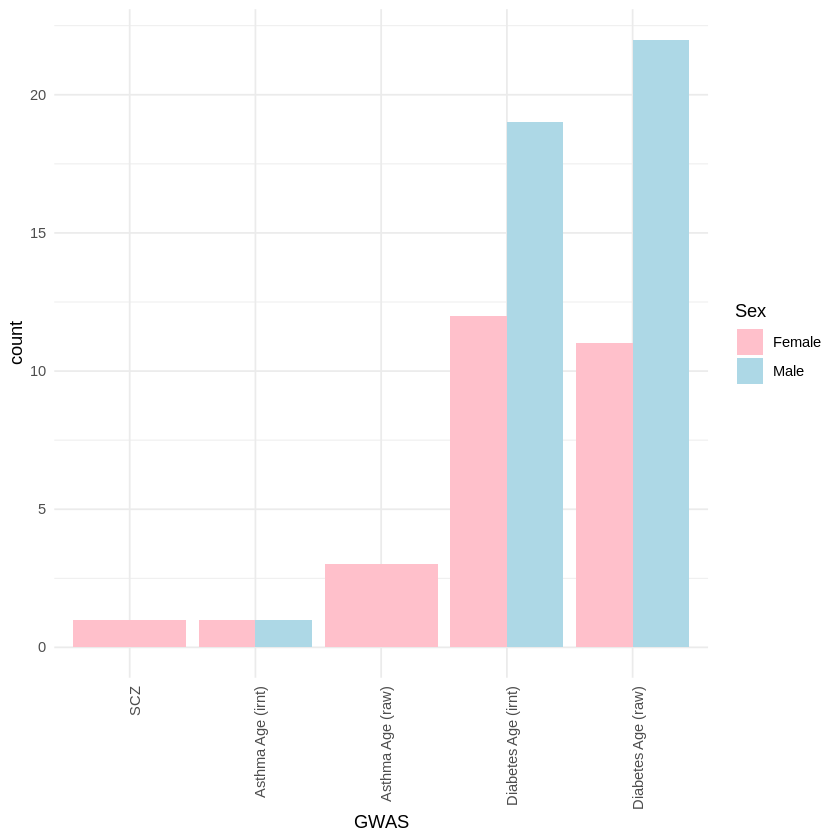

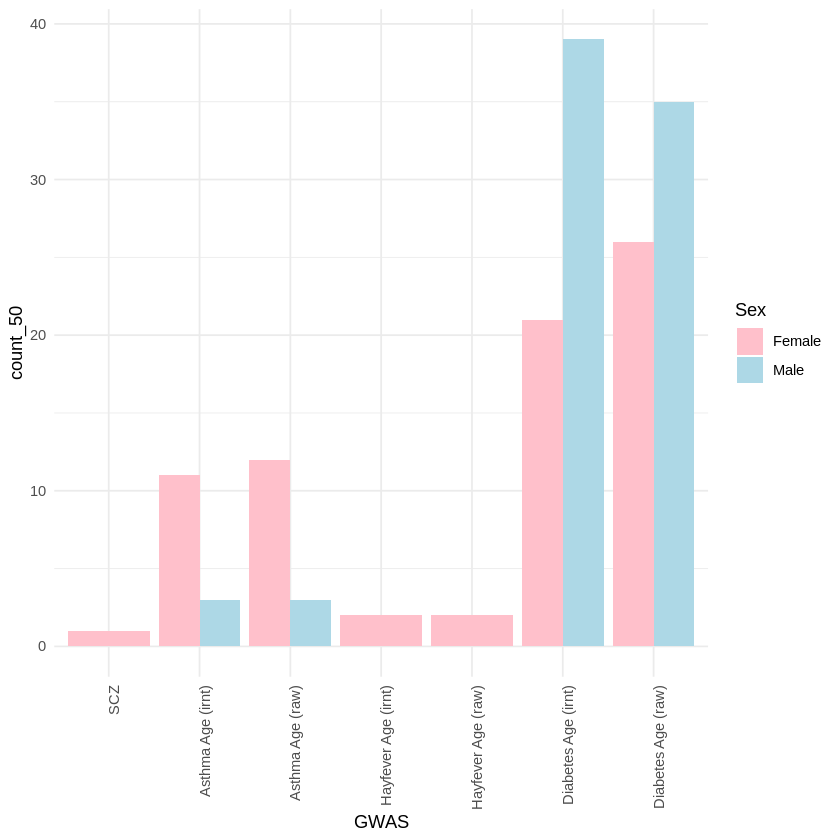

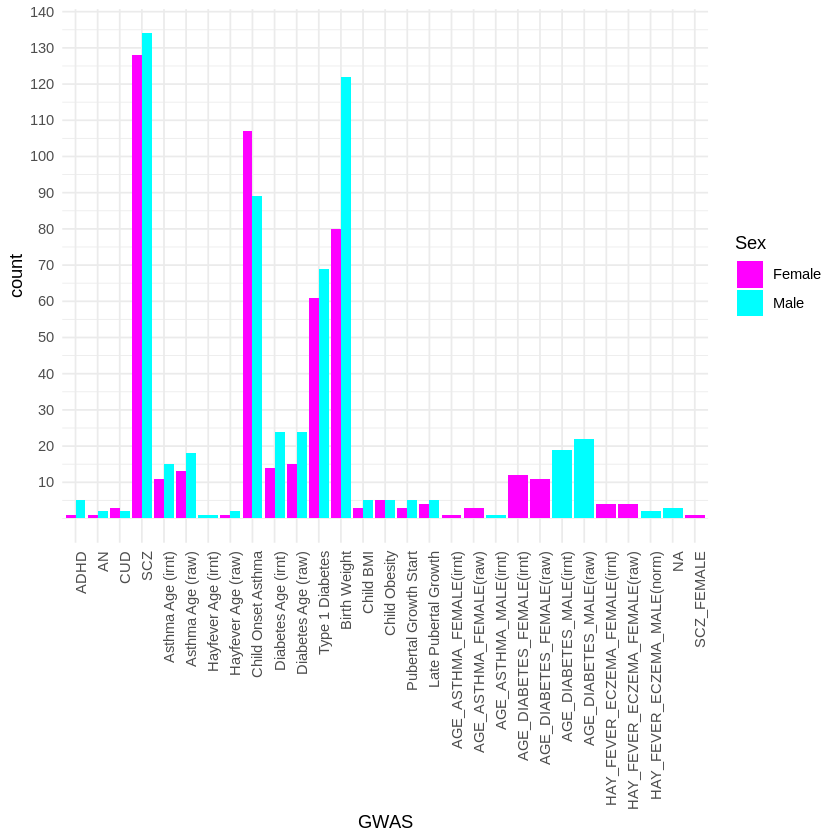

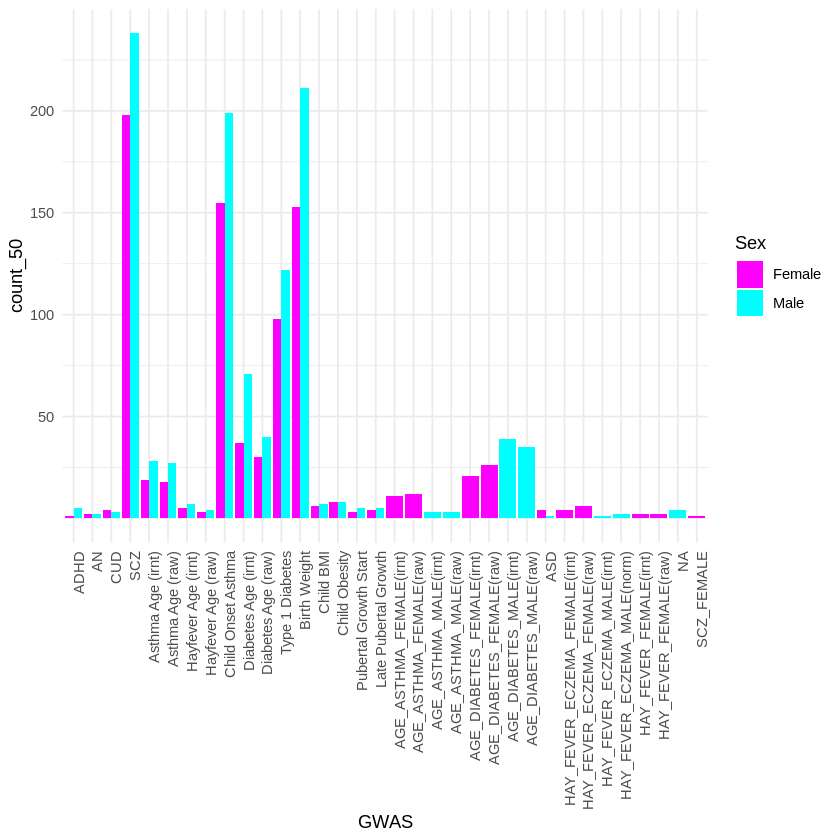

In [8]:
to_plot <- coloc_table[
    !grepl("MALE|BIP|ANX|MDD|TAG_CPD|AUDIT",GWAS),
    .(
        proportion = sum(PP.H4.abf > 0.9) / .N,
        count=sum(PP.H4.abf > 0.9),
        count_50 =sum(PP.H4.abf > 0.5)
    ),by=GWAS]
to_plot$GWAS <- recode_factor(
    to_plot$GWAS,
    "ADHD"="ADHD",
    "AN"="AN",
    "CUD"="CUD",
    "SCZ"="SCZ",
    "AGE_ASTHMA(irnt)" = "Asthma Age (irnt)",
    "AGE_ASTHMA(raw)" = "Asthma Age (raw)",
    "HAY_FEVER(irnt)" = "Hayfever Age (irnt)",
    "HAY_FEVER(raw)" = "Hayfever Age (raw)",
    "CHILD_ASTHMA" = "Child Onset Asthma",
    "AGE_DIABETES(irnt)" = "Diabetes Age (irnt)",
    "AGE_DIABETES(raw)" = "Diabetes Age (raw)",
    "Type 1 Diabetes"="Type 1 Diabetes",
    "EGG_BIRTH_WEIGHT_FETAL" = "Birth Weight",
    "EGG_BMI" = "Child BMI",
    "EGG_OBESITY" = "Child Obesity",
    "10F_12M" = "Pubertal Growth Start",
    "PGF_PGM" = "Late Pubertal Growth",
    "HAY_FEVER_ECZEMA(irnt)" = "Hayfever or Eczema Age (irnt)",
    "HAY_FEVER_ECZEMA(raw)" = "Hayfever or Eczema Age (raw)")

ggplot(
    to_plot[count != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count)
) +
geom_col(fill="dark red") +
scale_y_continuous(breaks=1:20 * 10)+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

ggplot(
    to_plot[count_50 != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count_50)
) +
geom_col(fill="dark red") +
scale_y_continuous(breaks=1:8 * 50)+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

to_plot <- coloc_table[
        grepl("MALE",GWAS),
        .(
            proportion = sum(PP.H4.abf > 0.9) / .N,
            count=sum(PP.H4.abf >0.9),
            count_50 = sum(PP.H4.abf >0.5)
        ),
        by=GWAS
    ]
to_plot <- to_plot[!grepl("BIP|ANX|MDD|TAG_CPD|AUDIT",GWAS),.(
        count,
        count_50,
        proportion,
        GWAS = gsub("_MALE|_FEMALE","",GWAS),
        Sex=ifelse(grepl("FEMALE",GWAS),"Female","Male")
    )
]
to_plot$GWAS <- recode_factor(
    to_plot$GWAS,
     "ADHD"="ADHD",
    "AN"="AN",
    "CUD"="CUD",
    "SCZ"="SCZ",
    "AGE_ASTHMA(irnt)" = "Asthma Age (irnt)",
    "AGE_ASTHMA(raw)" = "Asthma Age (raw)",
    "HAY_FEVER(irnt)" = "Hayfever Age (irnt)",
    "HAY_FEVER(raw)" = "Hayfever Age (raw)",
    "CHILD_ASTHMA" = "Child Onset Asthma",
    "AGE_DIABETES(irnt)" = "Diabetes Age (irnt)",
    "AGE_DIABETES(raw)" = "Diabetes Age (raw)",
    "Type 1 Diabetes"="Type 1 Diabetes",
    "EGG_BIRTH_WEIGHT_FETAL" = "Birth Weight",
    "EGG_BMI" = "Child BMI",
    "EGG_OBESITY" = "Child Obesity",
    "10F_12M" = "Pubertal Growth Start",
    "PGF_PGM" = "Late Pubertal Growth")
ggplot(
   to_plot[count != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count,fill=Sex)
) +
geom_col(position="dodge") +
scale_fill_manual(values=c("pink","light blue"))+
scale_y_continuous(breaks=seq(0,20,5))+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

ggplot(
   to_plot[count_50 != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count_50,fill=Sex)
) +
geom_col(position="dodge") +
scale_fill_manual(values=c("pink","light blue"))+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))


to_plot <- sex_coloc_table[,
        .(
            count=sum(PP.H4.abf >0.9),
            count_50 = sum(PP.H4.abf >0.5)
        ),
        by=GWAS
    ]
to_plot <- to_plot[!grepl("BIP|ANX|MDD|TAG_CPD|AUDIT",GWAS),.(
        count,
        count_50,
        GWAS = gsub("_male|_female","",GWAS),
        Sex=ifelse(grepl("female",GWAS),"Female","Male")
    )
]

to_plot$GWAS <- recode_factor(
    to_plot$GWAS,
    "ADHD"="ADHD",
    "AN"="AN",
    "CUD"="CUD",
    "SCZ"="SCZ",
    "AGE_ASTHMA(irnt)" = "Asthma Age (irnt)",
    "AGE_ASTHMA(raw)" = "Asthma Age (raw)",
    "HAY_FEVER(irnt)" = "Hayfever Age (irnt)",
    "HAY_FEVER(raw)" = "Hayfever Age (raw)",
    "CHILD_ASTHMA" = "Child Onset Asthma",
    "AGE_DIABETES(irnt)" = "Diabetes Age (irnt)",
    "AGE_DIABETES(raw)" = "Diabetes Age (raw)",
    "Type 1 Diabetes"="Type 1 Diabetes",
    "EGG_BIRTH_WEIGHT_FETAL" = "Birth Weight",
    "EGG_BMI" = "Child BMI",
    "EGG_OBESITY" = "Child Obesity",
    "10F_12M" = "Pubertal Growth Start",
    "PGF_PGM" = "Late Pubertal Growth"
)
ggplot(
   to_plot[count != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count,fill=Sex)
) +
geom_col(position="dodge") +
scale_fill_manual(values=c("magenta","cyan"))+
scale_y_continuous(breaks=1:20 * 10)+
theme_minimal()+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

ggplot(
   to_plot[count_50 != 0 & !grepl("EGG",GWAS)],
    aes(GWAS,count_50,fill=Sex)
) +
geom_col(position="dodge") +
scale_fill_manual(values=c("magenta","cyan"))+
theme_minimal()+
scale_y_continuous(breaks=1:8 * 50)+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

### Quick follow up experiments
1. Plot number of colocalized CpGs as function of trait heritability
2. Plot number of colocalized CpGs as a function of proportion of heritability explained by placental mQTL
3. Plot number of genes corresponding to colocalized CpGs

In [10]:
# load in heritability results
gwas_sample_sizes <- function(f){
    N <- fread(f,nrows=1)$N
    GWAS <- str_match(f,".*/(.*).sumstats.gz")[2]
    return(data.table(GWAS=GWAS,N=N))
}
part_heritability_results_independent <- function(path){
    part_heritability <- rbindlist(lapply(
          dir(
            path,
            pattern = "[marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female]_bin_CPP_her_.*.results$",
            full.names = TRUE
          ),
          function(f) {
            labels <- str_match(f, ".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(bin_CPP_her)_(.*).results$")[-c(1)]
            if (any(is.na(labels))) {
              return(data.table())
            } else {
              dt <- fread(f)[1, !"Category"]
              dt[, 
                `:=`(
                  Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
                  mQTL_group = labels[1],
                  annotation = labels[2],
                  GWAS = labels[3])]
              return(dt)
            }
          }
        ))
    log_files <- dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE
    )
    log_files <-log_files[!grepl("_shared",log_files)]
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE,
        
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*).log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[3] & annotation == labels[2]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[2],
            GWAS = labels[3]
          )
          return(dt)
        }
      }
    ))
    heritability <- heritability[which(!duplicated(GWAS))]
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}

part_heritability_results <- function(path,modifier){
    part_heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.results$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*){modifier}.results"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else {
          dt <- fread(f)
          dt[, 
            `:=`(
              Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
              annotation = labels[1],
              GWAS = labels[2])]
          return(dt)
        }
      }
    ))
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.log$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(bin_CPP_her)_(.*){modifier}.log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[2] & annotation == labels[1]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[1],
            GWAS = labels[2]
          )
          return(dt)
        }
      }
    ))
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}
annotation_SD <- function(path,file_pattern){
    annots <- rbindlist(mclapply(dir(path,full.names=TRUE,pattern=file_pattern),function(f) fread(f),mc.cores=22))
    return(apply(annots[,-c(1,2,3,4)],2,sd))    
}
pgc_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/")
neonatal_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/")

                                 
pgc_GWAS_key <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females",
    "meta_STDERR_rmdd_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "RMDD Males",
    "meta_STDERR_rmdd_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "RMDD Females",
    "ocd_aug2017" = "OCD",
    "OCD_meta_male_auto_072416.gz" = "OCD Males",
    "OCD_meta_female_auto_072416.gz" = "OCD Females",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "ukbb_anxiety.gwas.imputed_v3.both_sexes.tsv.gz.fixed" = "UKBB-ANX",
    "ukbb_anxiety.gwas.imputed_v3.male.tsv.gz.fixed" = "UKBB-ANX Males",
    "ukbb_anxiety.gwas.imputed_v3.female.tsv.gz.fixed" = "UKBB-ANX Females",
    "anxiety.meta.full.fs.tbl" = "ANXFS",
    "pgc_bip_2018" = "BIP",
    "meta_STDERR_bip_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "BIP Males",
    "meta_STDERR_bip_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "BIP Females",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "meta_STDERR_scz_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "SCZ Males",
    "meta_STDERR_scz_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "SCZ Females",
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "TS_Oct2018" = "TS",
    "pgc.cross.full.2013-03.txt" = "Cross Disorder",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day"
)
neonatal_GWAS_key <- c(
    "age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv" = "AGE_ASTHMA(norm)",
    "age_asthma_irnt.gwas.imputed_v3.female.tsv" = "ASTHMA Age(norm) Females",
    "age_asthma_irnt.gwas.imputed_v3.male.tsv"= "ASTHMA Age(norm) Males",
    "age_asthma_raw.gwas.imputed_v3.both_sexes.tsv" = "AGE_ASTHMA(raw)",
    "age_asthma_raw.gwas.imputed_v3.female.tsv" = "ASTHMA Age(raw) Females",
    "age_asthma_raw.gwas.imputed_v3.male.tsv" = "ASTHMA Age(raw) Males",
    "age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv" = "AGE_DIABETES(norm)",
    "age_diabetes_irnt.gwas.imputed_v3.female.tsv"= "DIABETES Age(norm) Females",
    "age_diabetes_irnt.gwas.imputed_v3.male.tsv"= "DIABETES Age(norm) Males",
    "age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv"= "AGE_DIABETES(raw)",
    "age_diabetes_raw.gwas.imputed_v3.female.tsv"= "DIABETES Age(raw) Females",
    "age_diabetes_raw.gwas.imputed_v3.male.tsv"= "DIABETES Age(raw) Males",
    "age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER(norm)",
    "age_hay_fever_irnt.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(norm) Females",
    "age_hay_fever_irnt.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(norm) Males",
    "age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER(raw)",
    "age_hay_fever_raw.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(raw) Females",
    "age_hay_fever_raw.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(raw) Males",
    "CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC" = "CHILD_ASTHMA",
    "EGG_BMI_HapMap_DISCOVERY.txt" = "EGG_BMI",
    "EGG_HC_DISCOVERY.v2.txt" = "Head Circumference",
    "EGG_Obesity_Meta_Analysis_1.txt" = "EGG_OBESITY",
    "EGG_TANNER_females.v2.txt" = "TANNER Stage Females",
    "EGG_TANNER_males_and_females_combined.v2.txt" = "TANNER Stage",
    "EGG_TANNER_males.v2.txt" = "TANNER Stage Males",
    "EGG-TotalGWG-Offspring.txt" = "GWG",
    "Pubertal_growth_10F_12M_combined.txt" = "10F_12M",
    "Pubertal_growth_10F.txt" = "Pubertal Growth Start Females",
    "Pubertal_growth_12M.txt" = "Pubertal Growth Start Males",
    "Pubertal_growth_PGF_PGM_combined.txt" = "PGF_PGM",
    "Pubertal_growth_PGF.txt" = "Total Pubertal Growth Females",
    "Pubertal_growth_PGM.txt" = "Total Pubertal Growth Males",
    "Pubertal_growth_PTF_PTM_combined.txt" = "PTF_PTM",
    "Pubertal_growth_PTF.txt" = "Late Pubertal Growth Females",
    "Pubertal_growth_PTM.txt" = "Late Pubertal Growth Males",
    "ukbb_preeclampsia.gwas.imputed_v3.female.tsv"= "Pre-Eclampsia During Pregnancy"
)
                                                                 
                                 
neonatal_part_heritability_independent_df <- neonatal_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key)) %>% na.omit()
                                 
pgc_part_heritability_independent_df <- pgc_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))  %>% na.omit()
                                 

In [11]:
manifest <- fread("../../450k_annotation.csv")  # Gene mapping

coloc_sex <- coloc_table %>%
    mutate(GWAS = as.character(GWAS)) %>% 
    mutate(
        Sex=ifelse(grepl("FEMALE",GWAS),"Female Only",ifelse(grepl("MALE",GWAS),"Male Only","Cross-sex")),
        GWAS = gsub("_MALE|_FEMALE","",GWAS)
    ) %>% 
    rbind(
        sex_coloc_table %>% 
        mutate(
            Sex=ifelse(grepl("female",GWAS),"Female-stratified","Male-stratified"),
            GWAS = gsub("_male|_female","",GWAS)
        )
    ) %>%
    mutate(
    GWAS =  as.character(recode_factor(
    GWAS,
    "ADHD"="ADHD",
    "AN"="AN",
    "CUD"="CUD",
    "SCZ"="SCZ",
    "AGE_ASTHMA(irnt)" = "Asthma Age (irnt)",
    "AGE_ASTHMA(raw)" = "Asthma Age (raw)",
    "HAY_FEVER(irnt)" = "Hayfever Age (irnt)",
    "HAY_FEVER(raw)" = "Hayfever Age (raw)",
    "HAY_FEVER_ECZEMA(irnt)" = "Hayfever or Eczema Age (irnt)",
    "HAY_FEVER_ECZEMA(raw)" = "Hayfever or Eczema Age (raw)",
    "CHILD_ASTHMA" = "Childhood Onset Asthma",
    "AGE_DIABETES(irnt)" = "Diabetes Age (irnt)",
    "AGE_DIABETES(raw)" = "Diabetes Age (raw)",
    "Type 1 Diabetes"="Type 1 Diabetes",
    "EGG_BIRTH_WEIGHT_FETAL" = "Birth Weight",
    "EGG_BMI" = "Childhood BMI",
    "EGG_OBESITY" = "Childhood Obesity",
    "10F_12M" = "Pubertal Growth Start",
    "PGF_PGM" = "Late Pubertal Growth",)))
unique(coloc_sex$Sex)
coloc_sex_manifest <- merge(coloc_sex,manifest[,.(Name,UCSC_RefGene_Name)],by.x="probe",by.y="Name") %>% filter(!grepl("EGG|BIP|ANX|MDD|TAG_CPD|AUDIT", GWAS))
all_data <- merge(merge(rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df)[Category == "Cross-sex"],coloc_table,by="GWAS"),manifest[,.(Name,UCSC_RefGene_Name)],by.x="probe",by.y="Name")

[1] "Cross-sex"         "Female Only"       "Male Only"        
[4] "Female-stratified" "Male-stratified"

In [8]:
df <- all_data[,.(count=sum(PP.H4.abf >0.9),h2,h2_std_error,Prop._h2),by="GWAS"]
df <- df[(h2 / h2_std_error) > 1.64]
ggplot(df%>% filter(count != 0),aes(count,h2, label=GWAS)) + 
    geom_point()+
    geom_text(hjust=0)+
    ggtitle(bquote(rho==.(round(cor.test(df$count,df$h2,method="spearman")$estimate,3))))


ggplot(df %>% filter(count != 0),aes(count,Prop._h2, label=GWAS)) + 
    geom_point()+
    geom_text(hjust=0)+
    ggtitle(bquote(rho==.(round(cor.test(df$count,df$Prop._h2,method="spearman")$estimate,3))))

ERROR: Error in eval(expr, envir, enclos): object 'all_data' not found


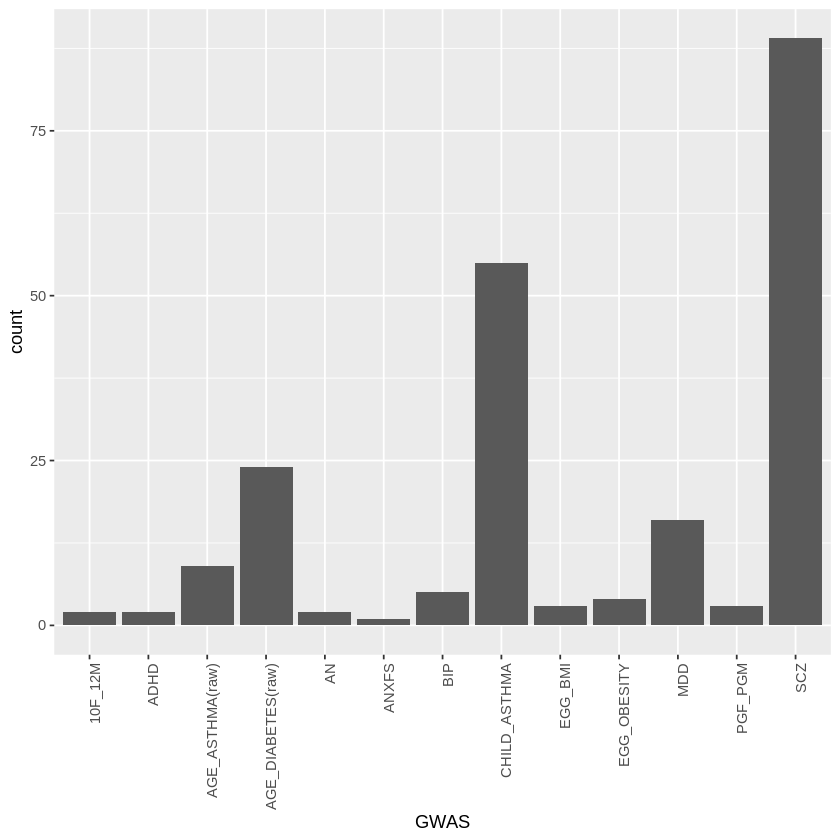

In [8]:
ggplot(
    all_data[PP.H4.abf >0.9,.(count=uniqueN(gsub(";.*","",UCSC_RefGene_Name))),by=GWAS],
    aes(GWAS,count)
) +
geom_col() +
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

### Writing out data to a single table

In [12]:
to_write <- coloc_sex_manifest%>% filter(PP.H4.abf > 0.9,!grepl("EGG|BIP|ANX|MDD|TAG_CPD|AUDIT|Hayfever Age|Asthma Age|Diabetes Age",GWAS))
to_write$gene <- to_write$UCSC_RefGene_Name
to_write$UCSC_RefGene_Name <- NULL
to_write$gene <- gsub(";.*","",to_write$gene)

to_write %>%
    filter(!grepl("EGG",GWAS))%>%
    select(Sex,GWAS,probe,gene,everything()) %>%
    arrange(GWAS,Sex,-PP.H4.abf) %>%
    write_csv(here("data","all_PH4_coloc.csv")) 


to_write <- coloc_sex_manifest%>% filter(PP.H4.abf > 0.5,!grepl("EGG|BIP|ANX|MDD|TAG_CPD|AUDIT|Hayfever Age|Asthma Age|Diabetes Age",GWAS))
to_write$gene <- to_write$UCSC_RefGene_Name
to_write$UCSC_RefGene_Name <- NULL
to_write$gene <- gsub(";.*","",to_write$gene)

to_write %>%
    filter(!grepl("EGG",GWAS))%>%
    select(Sex,GWAS,probe,gene,everything()) %>%
    arrange(GWAS,Sex,-PP.H4.abf) %>%
    write_csv(here("data","all_PH4_50_coloc.csv")) 

### More involved follow-up
Intersection/difference in loci found for sex stratified GWAS & sex stratified placental mQTL vs cross-sex GWAS & cross-sex placental mQTL

In [13]:
head(coloc_sex_manifest)
summary(coloc_sex_manifest)

probe,GWAS,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Sex,UCSC_RefGene_Name
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cg00022866,Type 1 Diabetes,151,1.965773e-21,3.114833e-05,6.310795e-17,0.9999668,2.066185e-06,Cross-sex,CCDC88B
cg00022866,Type 1 Diabetes,100,8.555145e-12,7.960239e-04,1.073818e-08,0.9991467,5.727657e-05,Female-stratified,CCDC88B
cg00022866,Type 1 Diabetes,116,3.251894e-17,6.865923e-05,4.735935e-13,0.9999268,4.529512e-06,Male-stratified,CCDC88B
cg00022997,Diabetes Age (irnt),112,7.788005e-08,3.203858e-03,2.417545e-05,0.9945362,2.235684e-03,Female Only,
cg00022997,Diabetes Age (raw),112,2.040028e-13,8.392340e-09,2.424935e-05,0.9975761,2.399623e-03,Female Only,
cg00022997,Diabetes Age (irnt),143,1.699830e-10,7.224259e-06,2.230575e-05,0.9479395,5.203097e-02,Male Only,


    probe               GWAS               nsnps          PP.H0.abf        
 Length:39702       Length:39702       Min.   :   2.0   Min.   :0.000e+00  
 Class :character   Class :character   1st Qu.: 136.0   1st Qu.:0.000e+00  
 Mode  :character   Mode  :character   Median : 285.0   Median :0.000e+00  
                                       Mean   : 358.1   Mean   :1.279e-05  
                                       3rd Qu.: 478.0   3rd Qu.:0.000e+00  
                                       Max.   :1816.0   Max.   :5.658e-02  
   PP.H1.abf           PP.H2.abf          PP.H3.abf        PP.H4.abf        
 Min.   :0.000e+00   Min.   :0.000000   Min.   :0.0000   Min.   :0.0000000  
 1st Qu.:0.000e+00   1st Qu.:0.000000   1st Qu.:0.9878   1st Qu.:0.0000000  
 Median :1.000e-08   Median :0.000000   Median :0.9998   Median :0.0000329  
 Mean   :1.448e-03   Mean   :0.006131   Mean   :0.9004   Mean   :0.0919845  
 3rd Qu.:1.380e-04   3rd Qu.:0.000010   3rd Qu.:1.0000   3rd Qu.:0.0036809  
 Max. 

####  UpSet Plots

In [15]:
library(ComplexUpset)
unique(coloc_sex_manifest$GWAS)

selected_traits <- c(
    'ADHD',
    'SCZ',
    'AN',
    'CUD',
    'Asthma Age',
    'Childhood Onset Asthma',
    'Hayfever Age',
    'Diabetes Age',
    'Type 1 Diabetes',
    'Birth Weight',
    'Pubertal Growth Start',
    'Hayfever Age (irnt)',
    'Childhood BMI',
    'Childhood Obesity',
    'Late Pubertal Growth',
    'PTF_PTM',
    'GWG',
    'ASD',
    'FETAL_PREECLAMPSIA'
)

Warning message:
“package ‘ComplexUpset’ was built under R version 4.1.1”


[1] "Type 1 Diabetes"               "Diabetes Age (irnt)"          
 [3] "Diabetes Age (raw)"            "Childhood Onset Asthma"       
 [5] "SCZ"                           "AGE_DIABETES_FEMALE(irnt)"    
 [7] "AGE_DIABETES_FEMALE(raw)"      "AGE_DIABETES_MALE(irnt)"      
 [9] "AGE_DIABETES_MALE(raw)"        "Asthma Age (irnt)"            
[11] "Asthma Age (raw)"              "AGE_ASTHMA_MALE(irnt)"        
[13] "AGE_ASTHMA_MALE(raw)"          "HAY_FEVER_ECZEMA_MALE(norm)"  
[15] "Birth Weight"                  "Pubertal Growth Start"        
[17] "AGE_ASTHMA_FEMALE(irnt)"       "AGE_ASTHMA_FEMALE(raw)"       
[19] "Hayfever Age (irnt)"           "Hayfever Age (raw)"           
[21] "CUD"                           "Childhood BMI"                
[23] "Childhood Obesity"             "AN"                           
[25] "NA"                            "HAY_FEVER_ECZEMA_FEMALE(irnt)"
[27] "HAY_FEVER_ECZEMA_FEMALE(raw)"  "HAY_FEVER_FEMALE(irnt)"       
[29] "HAY_FEVER_FEMALE(raw)"         "Late Pubertal Growth"         
[31] "SCZ_FEMALE"                    "PTF_PTM"                      
[33] "ADHD"                          "GWG"                          
[35] "ASD"                           "HAY_FEVER_ECZEMA_MALE(irnt)"  
[37] "FETAL_PREECLAMPSIA"

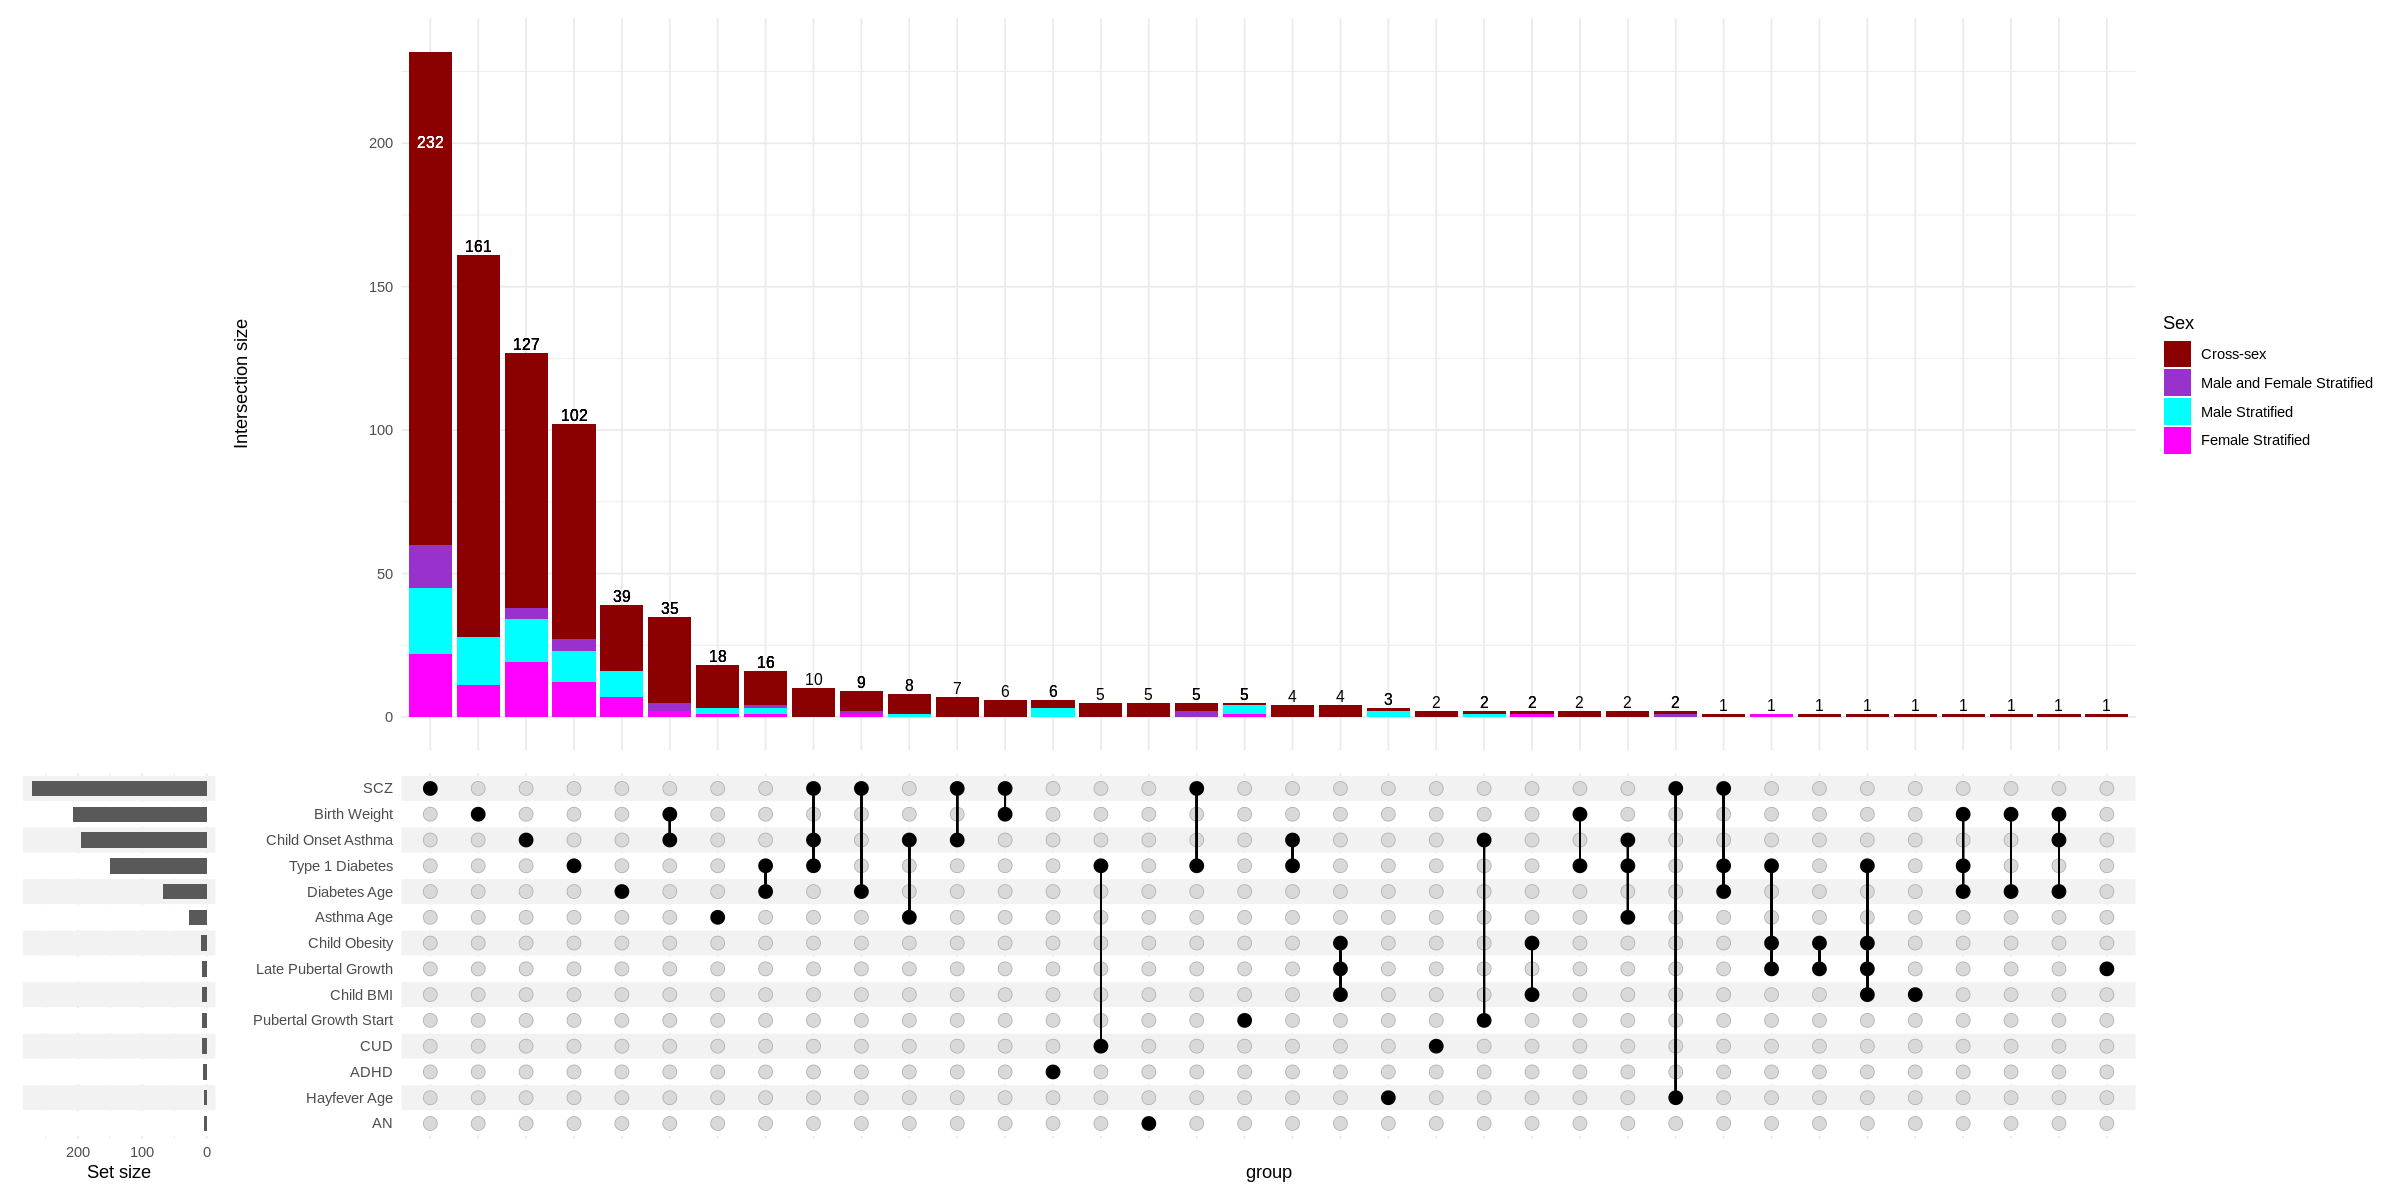

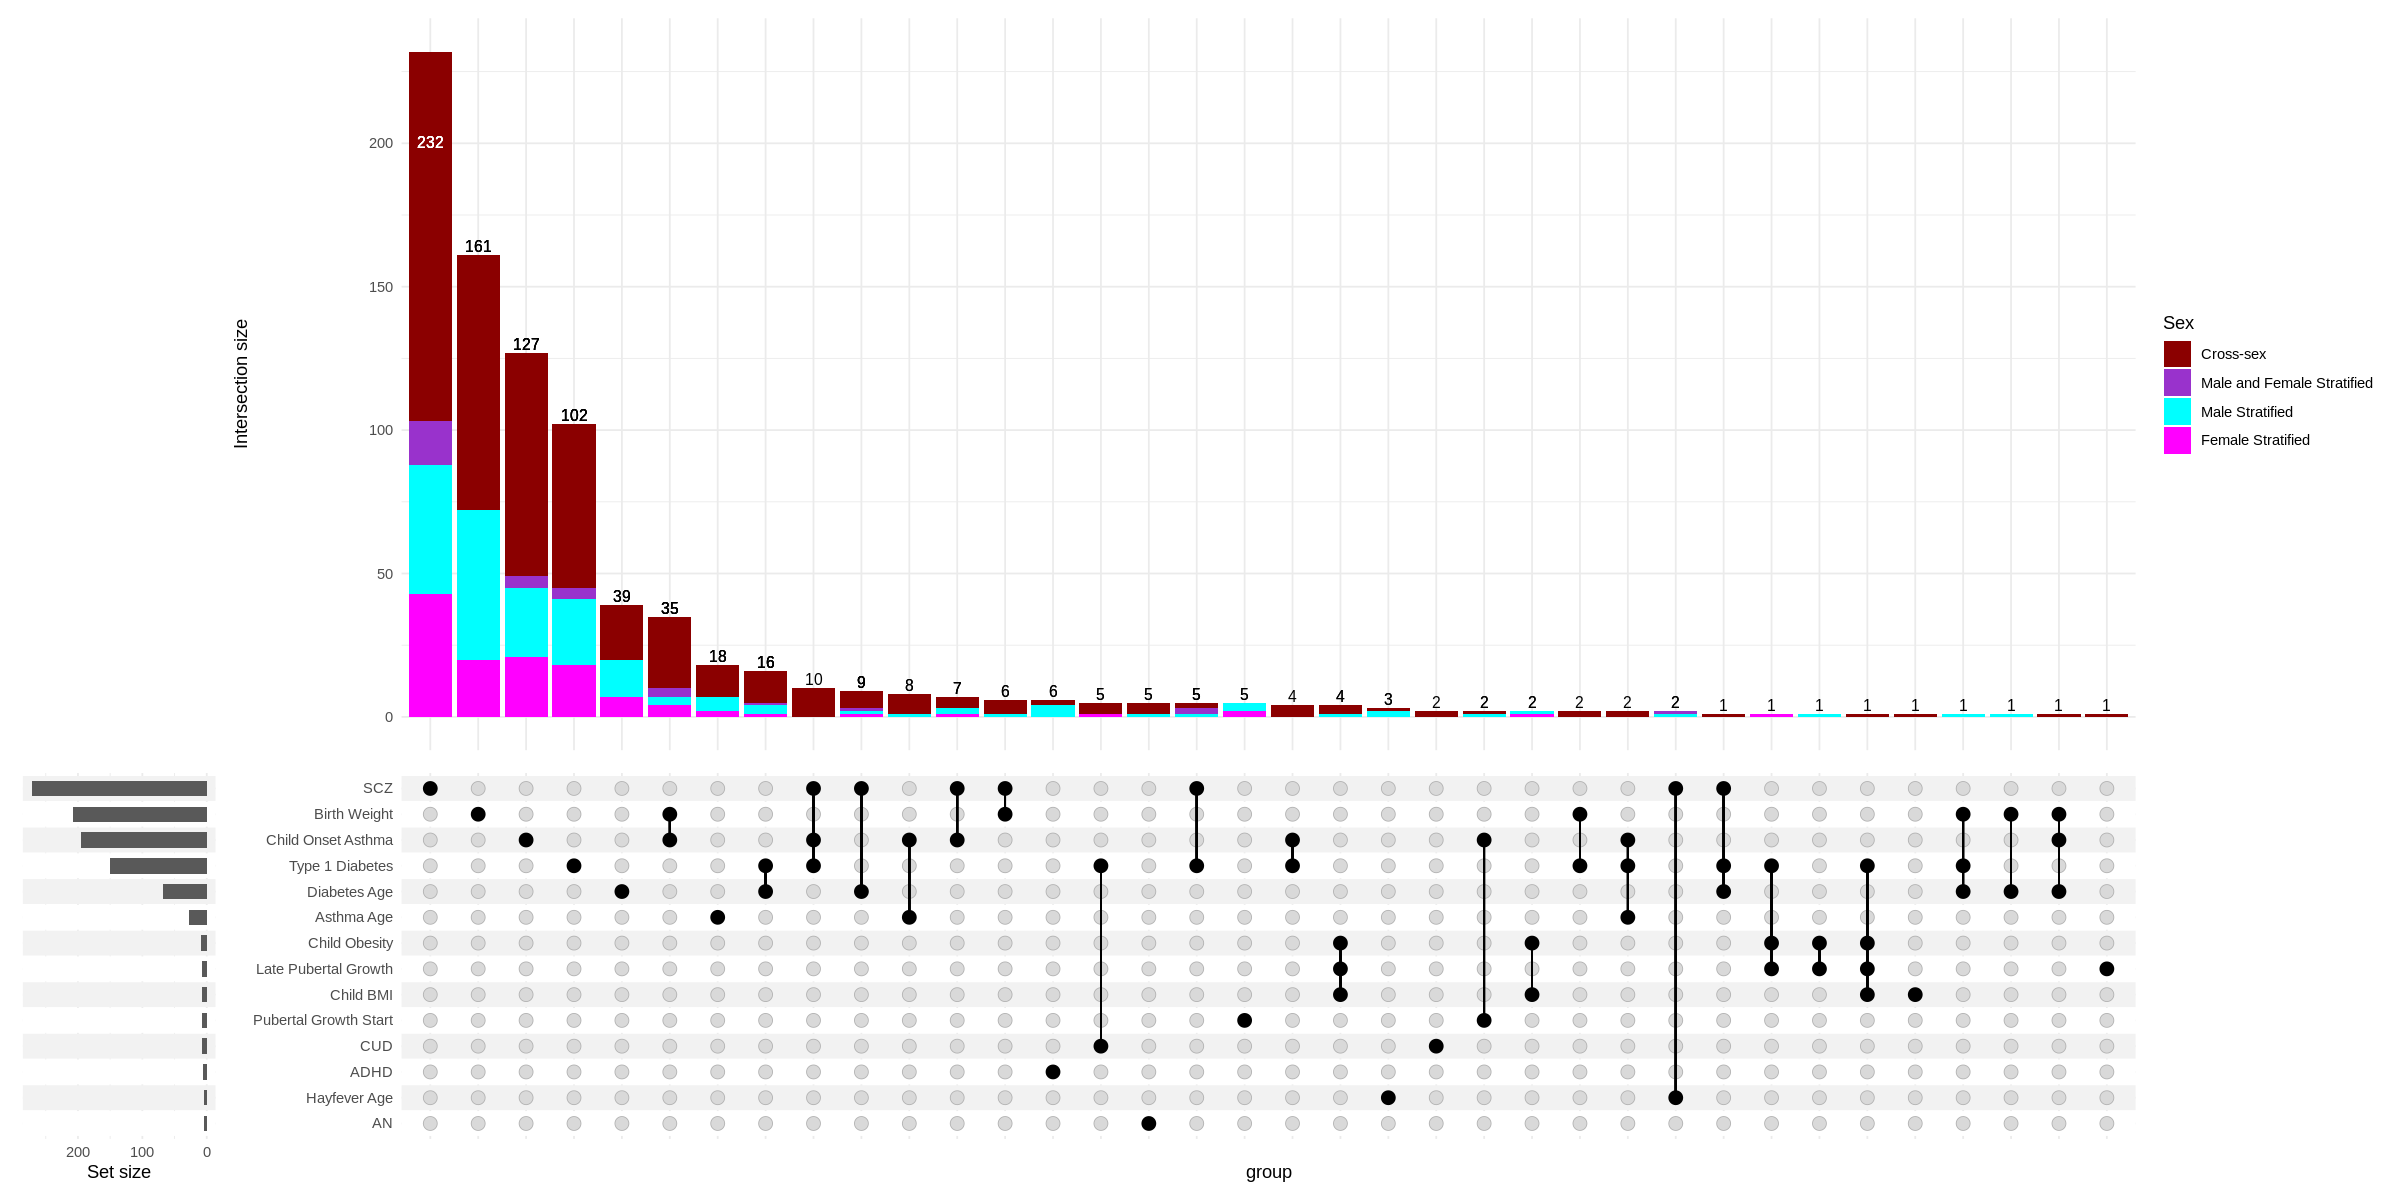

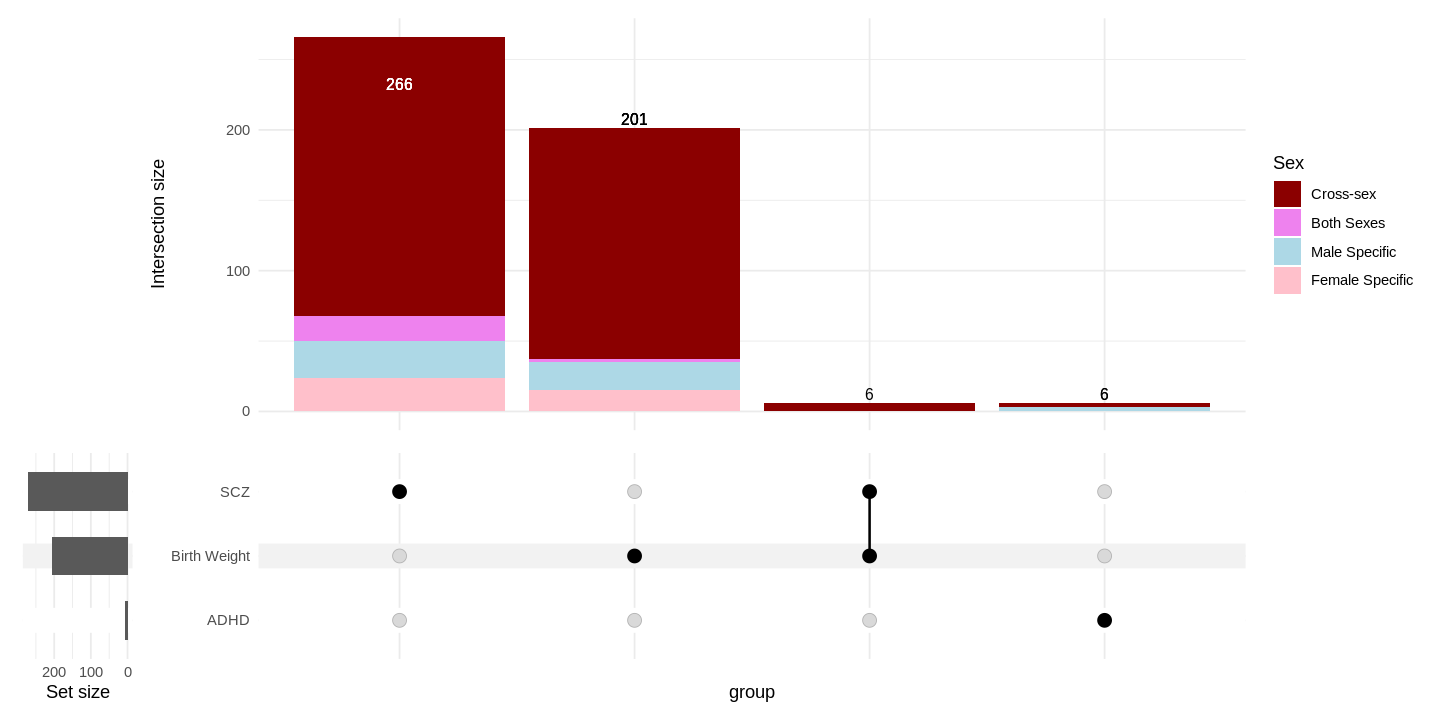

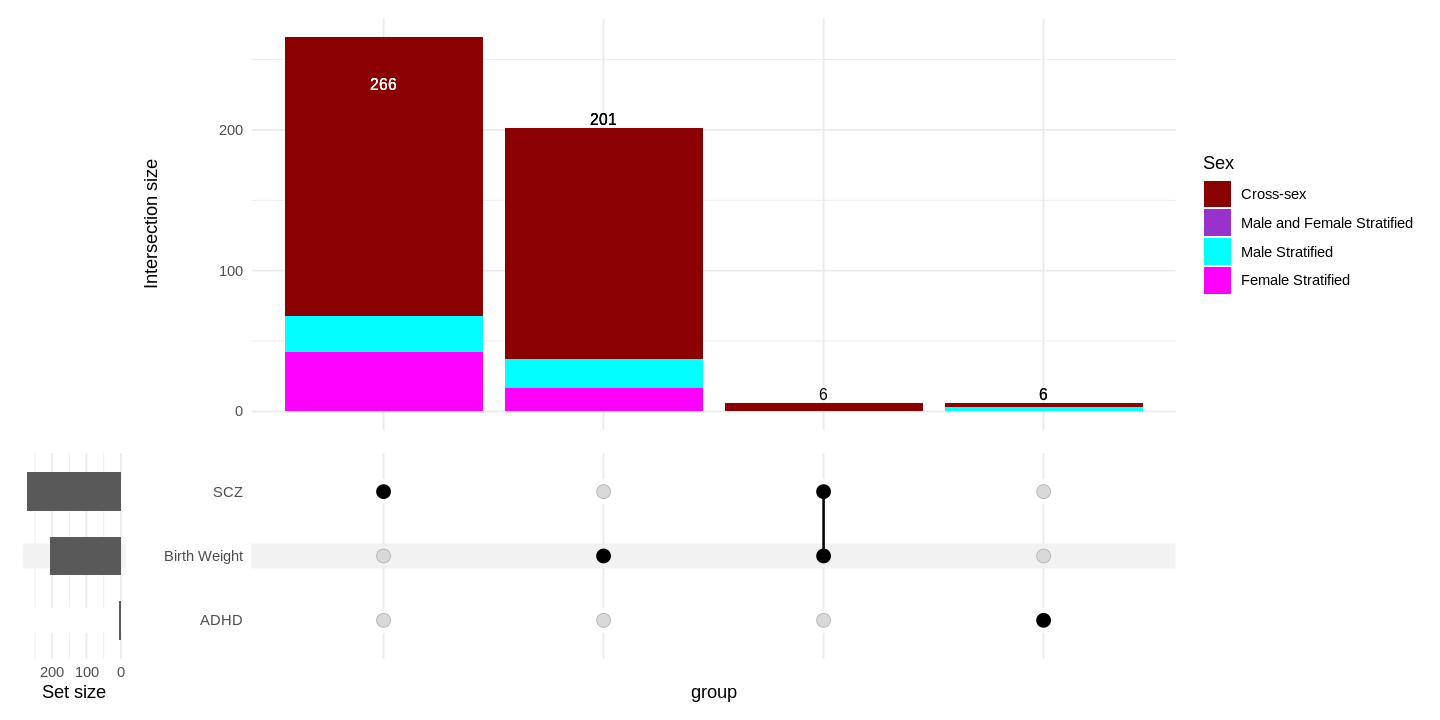

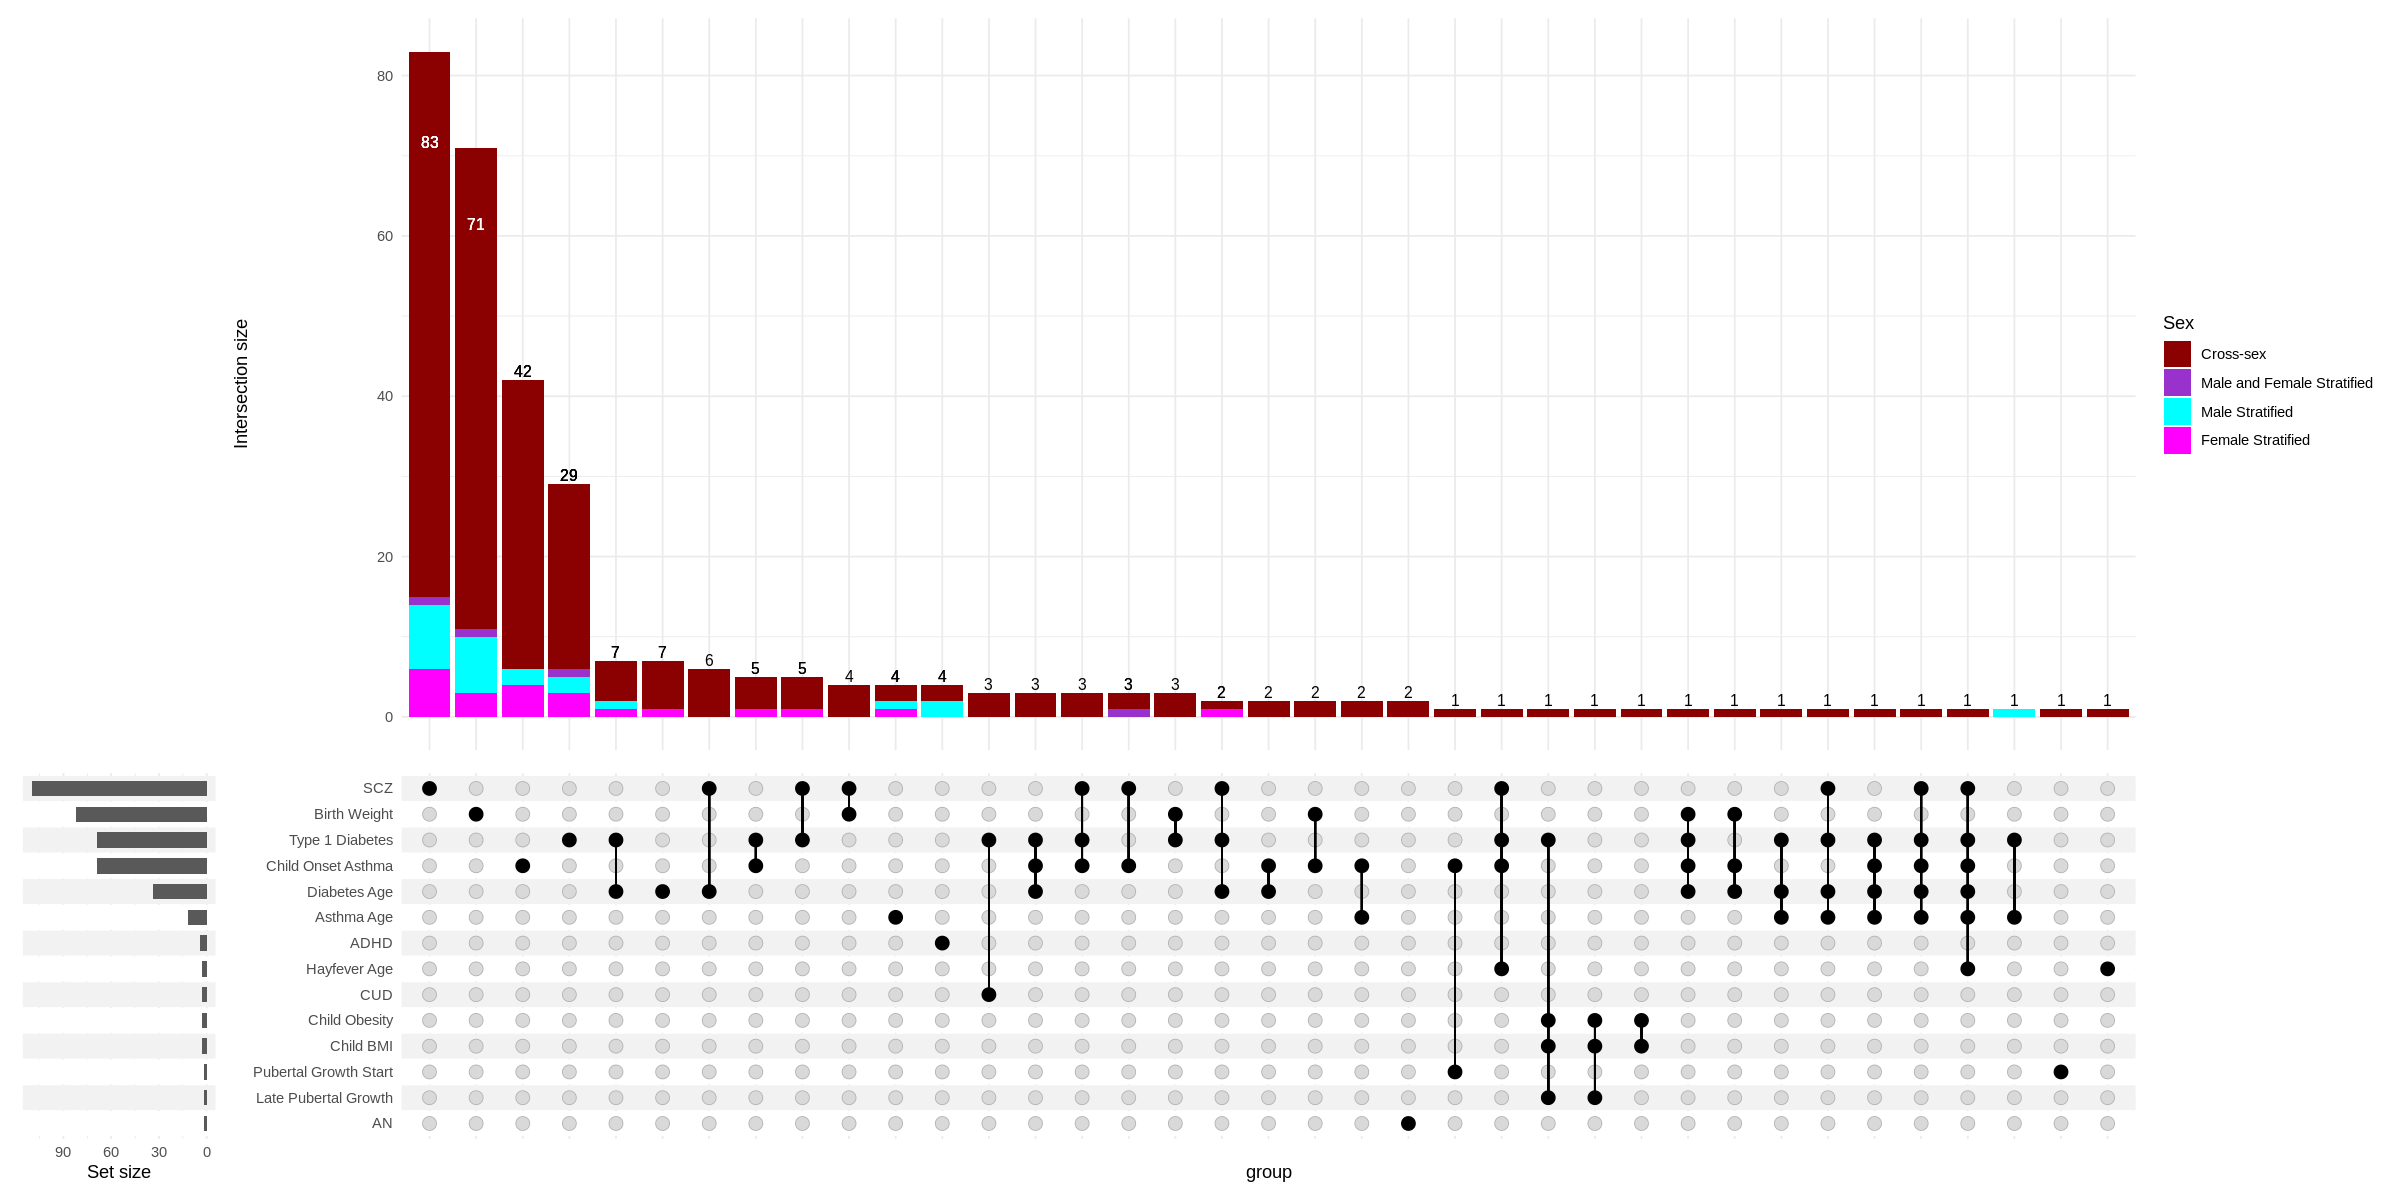

In [15]:
options(jupyter.plot_mimetypes = "image/svg+xml") 
generate_sex_input <- function(df,ph4_thresh=0.9){
    require(tidyverse)
    tmp <- df %>% filter(PP.H4.abf > ph4_thresh)
    groups <- split(tmp$probe,tmp$GWAS)
    probes <- unique(unlist(groups))
    out <- UpSetR::fromList(groups) == 1
    meta <- data.frame(Sex= sapply(probes,function(x) paste(unique(tmp[probe == x]$Sex),collapse = ", ")))
    return(cbind(meta,out) %>% rownames_to_column(var="probe"))
}
set_size = function(w, h, factor=1.5) {
    s = 1 * factor
    options(
        repr.plot.width=w * s,
        repr.plot.height=h * s,
        repr.plot.res=120,
        jupyter.plot_mimetypes='image/png',
        jupyter.plot_scale=1
    )
}
                                   
dat <- generate_sex_input(coloc_sex_manifest[Sex %in% c("Cross-sex", "Male Stratified", "Female Stratified")])
GWAS <- colnames(dat)[3:ncol(dat)]
# Cross-sex vs not
set_size(10, 5,factor=2)                            
color_key <- c("Cross-sex"="dark red",'Male and Female Stratified'='darkorchid',
            'Male Stratified'='cyan', 'Female Stratified'='magenta')                                
to_plot <-     dat %>% 
        mutate(
            Sex =factor( ifelse(
                grepl("Cross-sex",Sex),
                ifelse(
                    grepl("^Cross-sex$",Sex),
                    "Cross-sex",
                    ifelse(
                        grepl("Male",Sex),
                        ifelse(
                            grepl("Female",Sex),
                            "Cross-sex",# and Both Sexes",
                            "Cross-sex"
                        ),
                        "Cross-sex"
                    )
                ),
                ifelse(
                    grepl("Male",Sex),
                    ifelse(
                        grepl("Female",Sex),
                        "Male and Female Stratified",
                        "Male Stratified"
                    ),
                    "Female Stratified"
                )
            ),
            levels = names(color_key))
        )
p<- ComplexUpset::upset(
    to_plot,
    GWAS,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=TRUE,
            mapping=aes(fill=Sex),
            text=list(size=3.3)
        )+ scale_fill_manual(values=color_key)
    ),
    width_ratio=0.1
)
ggsave('upset_cpg_cross_vs_not.svg',p,width=10,height=3)
print(p)   
cross_vs_not_dat <- to_plot                                 
#Cross-sex only vs not                                   
p<- ComplexUpset::upset(
    dat %>% 
        mutate(
             Sex =factor( ifelse(
                grepl("Cross-sex",Sex),
                ifelse(
                    grepl("^Cross-sex$",Sex),
                    "Cross-sex",
                    ifelse(
                        grepl("Male",Sex),
                        ifelse(
                            grepl("Female",Sex),
                            "Cross-sex",
                            "Male Stratified"
                        ),
                        "Female Stratified"
                    )
                ),
                ifelse(
                    grepl("Male",Sex),
                    ifelse(
                        grepl("Female",Sex),
                        "Male and Female Stratified",
                        "Male Stratified"
                    ),
                    "Female Stratified"
                )
            ),
            levels = names(color_key))
        ),
    GWAS,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=TRUE,
            mapping=aes(fill=Sex),
            text=list(size=3.3)
        )+ scale_fill_manual(values=color_key)
    ),
    width_ratio=0.1
)
ggsave('upset_cpg_cross_only_vs_not.svg',p,width=10,height=3)                                                                      
print(p)
dat <- generate_sex_input(coloc_sex_manifest[GWAS %in% c( "ASD", "ADHD", "SCZ", "Birth Weight","Birth Length")& Sex %in% c("Cross-sex", "Male Stratified", "Female Stratified")])
GWAS <- colnames(dat)[3:ncol(dat)]
# Cross-sex vs not
set_size(6, 3,factor=2)
color_key <- c("Cross-sex"="dark red",'Both Sexes'='violet',
            'Male Specific'='light blue', 'Female Specific'='pink') 
dat <- dat %>% 
    mutate(
        Sex =factor( ifelse(
            grepl("Cross-sex",Sex),
            ifelse(
                grepl("^Cross-sex$",Sex),
                "Cross-sex",
                ifelse(
                    grepl("Male",Sex),
                    ifelse(
                        grepl("Female",Sex),
                        "Cross-sex",# and Both Sexes",
                        "Cross-sex"
                    ),
                    "Cross-sex"
                )
            ),
            ifelse(
                grepl("Male",Sex),
                ifelse(
                    grepl("Female",Sex),
                    "Both Sexes",
                    "Male Specific"
                ),
                "Female Specific"
            )
        ),
        levels = names(color_key))
    )
                       
p<- ComplexUpset::upset(
    dat,
    GWAS,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=TRUE,
            mapping=aes(fill=Sex),
            text=list(size=3.3)
        )+ scale_fill_manual(values=color_key)
    ),
    width_ratio=0.1
)
ggsave('upset_selected_cross_vs_not.svg',p,units = 'in',width=10,height=3)    
print(p)
# Cross-sex only vs not                                 
color_key <- c("Cross-sex"="dark red",'Male and Female Stratified'='darkorchid',
            'Male Stratified'='cyan', 'Female Stratified'='magenta')                                
p <- ComplexUpset::upset(
    dat %>% 
        mutate(
            Sex =factor( ifelse(
                grepl("Cross-sex",Sex),
                ifelse(
                    grepl("^Cross-sex$",Sex),
                    "Cross-sex",
                    ifelse(
                        grepl("Male",Sex),
                        ifelse(
                            grepl("Female",Sex),
                            "Cross-sex",
                            "Male Stratified"
                        ),
                        "Female Stratified"
                    )
                ),
                ifelse(
                    grepl("Male",Sex),
                    ifelse(
                        grepl("Female",Sex),
                        "Male and Female Stratified",
                        "Male Stratified"
                    ),
                    "Female Stratified"
                )
            ),
            levels = names(color_key))
        ),
    GWAS,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=TRUE,
            mapping=aes(fill=Sex),
            text=list(size=3.3)
        )+ scale_fill_manual(values=color_key)
    ),
    width_ratio=0.1
)
ggsave('upset_selected_cross_only_vs_not.svg',p,width=10,height=3)
print(p)       
## Plotted for corresponding genes                                   
tmp <-coloc_sex_manifest[Sex %in% c("Cross-sex", "Male Stratified", "Female Stratified")]
tmp[,`:=`(probe = gsub(";.*","",UCSC_RefGene_Name))]                                   
dat <- generate_sex_input(tmp[probe != ""])
GWAS <- colnames(dat)[3:ncol(dat)]
# Cross-sex vs not                                 

set_size(10, 5,factor=2)
color_key <- c("Cross-sex"="dark red",'Male and Female Stratified'='darkorchid',
            'Male Stratified'='cyan', 'Female Stratified'='magenta')                                
to_plot <- dat %>% 
        mutate(
            Sex =factor( ifelse(
                grepl("Cross-sex",Sex),
                ifelse(
                    grepl("^Cross-sex$",Sex),
                    "Cross-sex",
                    ifelse(
                        grepl("Male",Sex),
                        ifelse(
                            grepl("Female",Sex),
                            "Cross-sex",# and Both Sexes",
                            "Cross-sex"
                        ),
                        "Cross-sex"
                    )
                ),
                ifelse(
                    grepl("Male",Sex),
                    ifelse(
                        grepl("Female",Sex),
                        "Male and Female Stratified",
                        "Male Stratified"
                    ),
                    "Female Stratified"
                )
            ),
            levels = names(color_key))
        )
p<-ComplexUpset::upset(
    to_plot,
    GWAS,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=TRUE,
            mapping=aes(fill=Sex),
            text=list(size=3.3)
        )+ scale_fill_manual(values=color_key)
    ),
    width_ratio=0.1
)
ggsave('upset_gene_cross_vs_not.svg',p,width=20,height=5)       
print(p) 
cross_vs_not_gene_dat <- to_plot

In [15]:
selected_traits <- c(
    'ADHD',
    'SCZ',
    'AN',
    'CUD',
#     'Asthma Age',
    'Child Onset Asthma',
    'Hayfever or Eczema Age',
    'Type 1 Diabetes',
    'Birth Weight',
    'Child BMI',
    'Child Obesity',
    'Pubertal Growth Start',
    'Late Pubertal Growth'
)
coloc_sex_manifest$GWAS <- recode(gsub(" \\(.*","",coloc_sex_manifest$GWAS),'Childhood BMI'='Child BMI','Childhood Onset Asthma'='Child Onset Asthma','Childhood Obesity'= 'Child Obesity')
colocalization_by_probe <- coloc_sex_manifest[
    PP.H4.abf > 0.9 &
    GWAS %in% selected_traits,
    .(Sex=paste0(unique(Sex[order(Sex)]),collapse=",")),
    by=c("probe","GWAS")
][,.(hits=.N,probe=paste0(unique(probe),collapse=",")),by=c("Sex","GWAS")]
fwrite(colocalization_by_probe,file=here("data","colocalization_by_probe.csv"))
coloc_sex_manifest_gene <- coloc_sex_manifest[UCSC_RefGene_Name != ""]
coloc_sex_manifest_gene$UCSC_RefGene_Name <- gsub(";.*","",coloc_sex_manifest_gene$UCSC_RefGene_Name)

colocalization_by_gene <- coloc_sex_manifest_gene[
    PP.H4.abf > 0.9 &
    GWAS %in% selected_traits,
    .(Sex= paste0(unique(Sex[order(Sex)]),collapse=",")),
    by=c("UCSC_RefGene_Name","GWAS")
][,.(hits=.N,gene=paste0(unique(UCSC_RefGene_Name),collapse=",")),by=c("Sex","GWAS")]
fwrite(colocalization_by_gene,file=here("data","colocalization_by_gene.csv"))


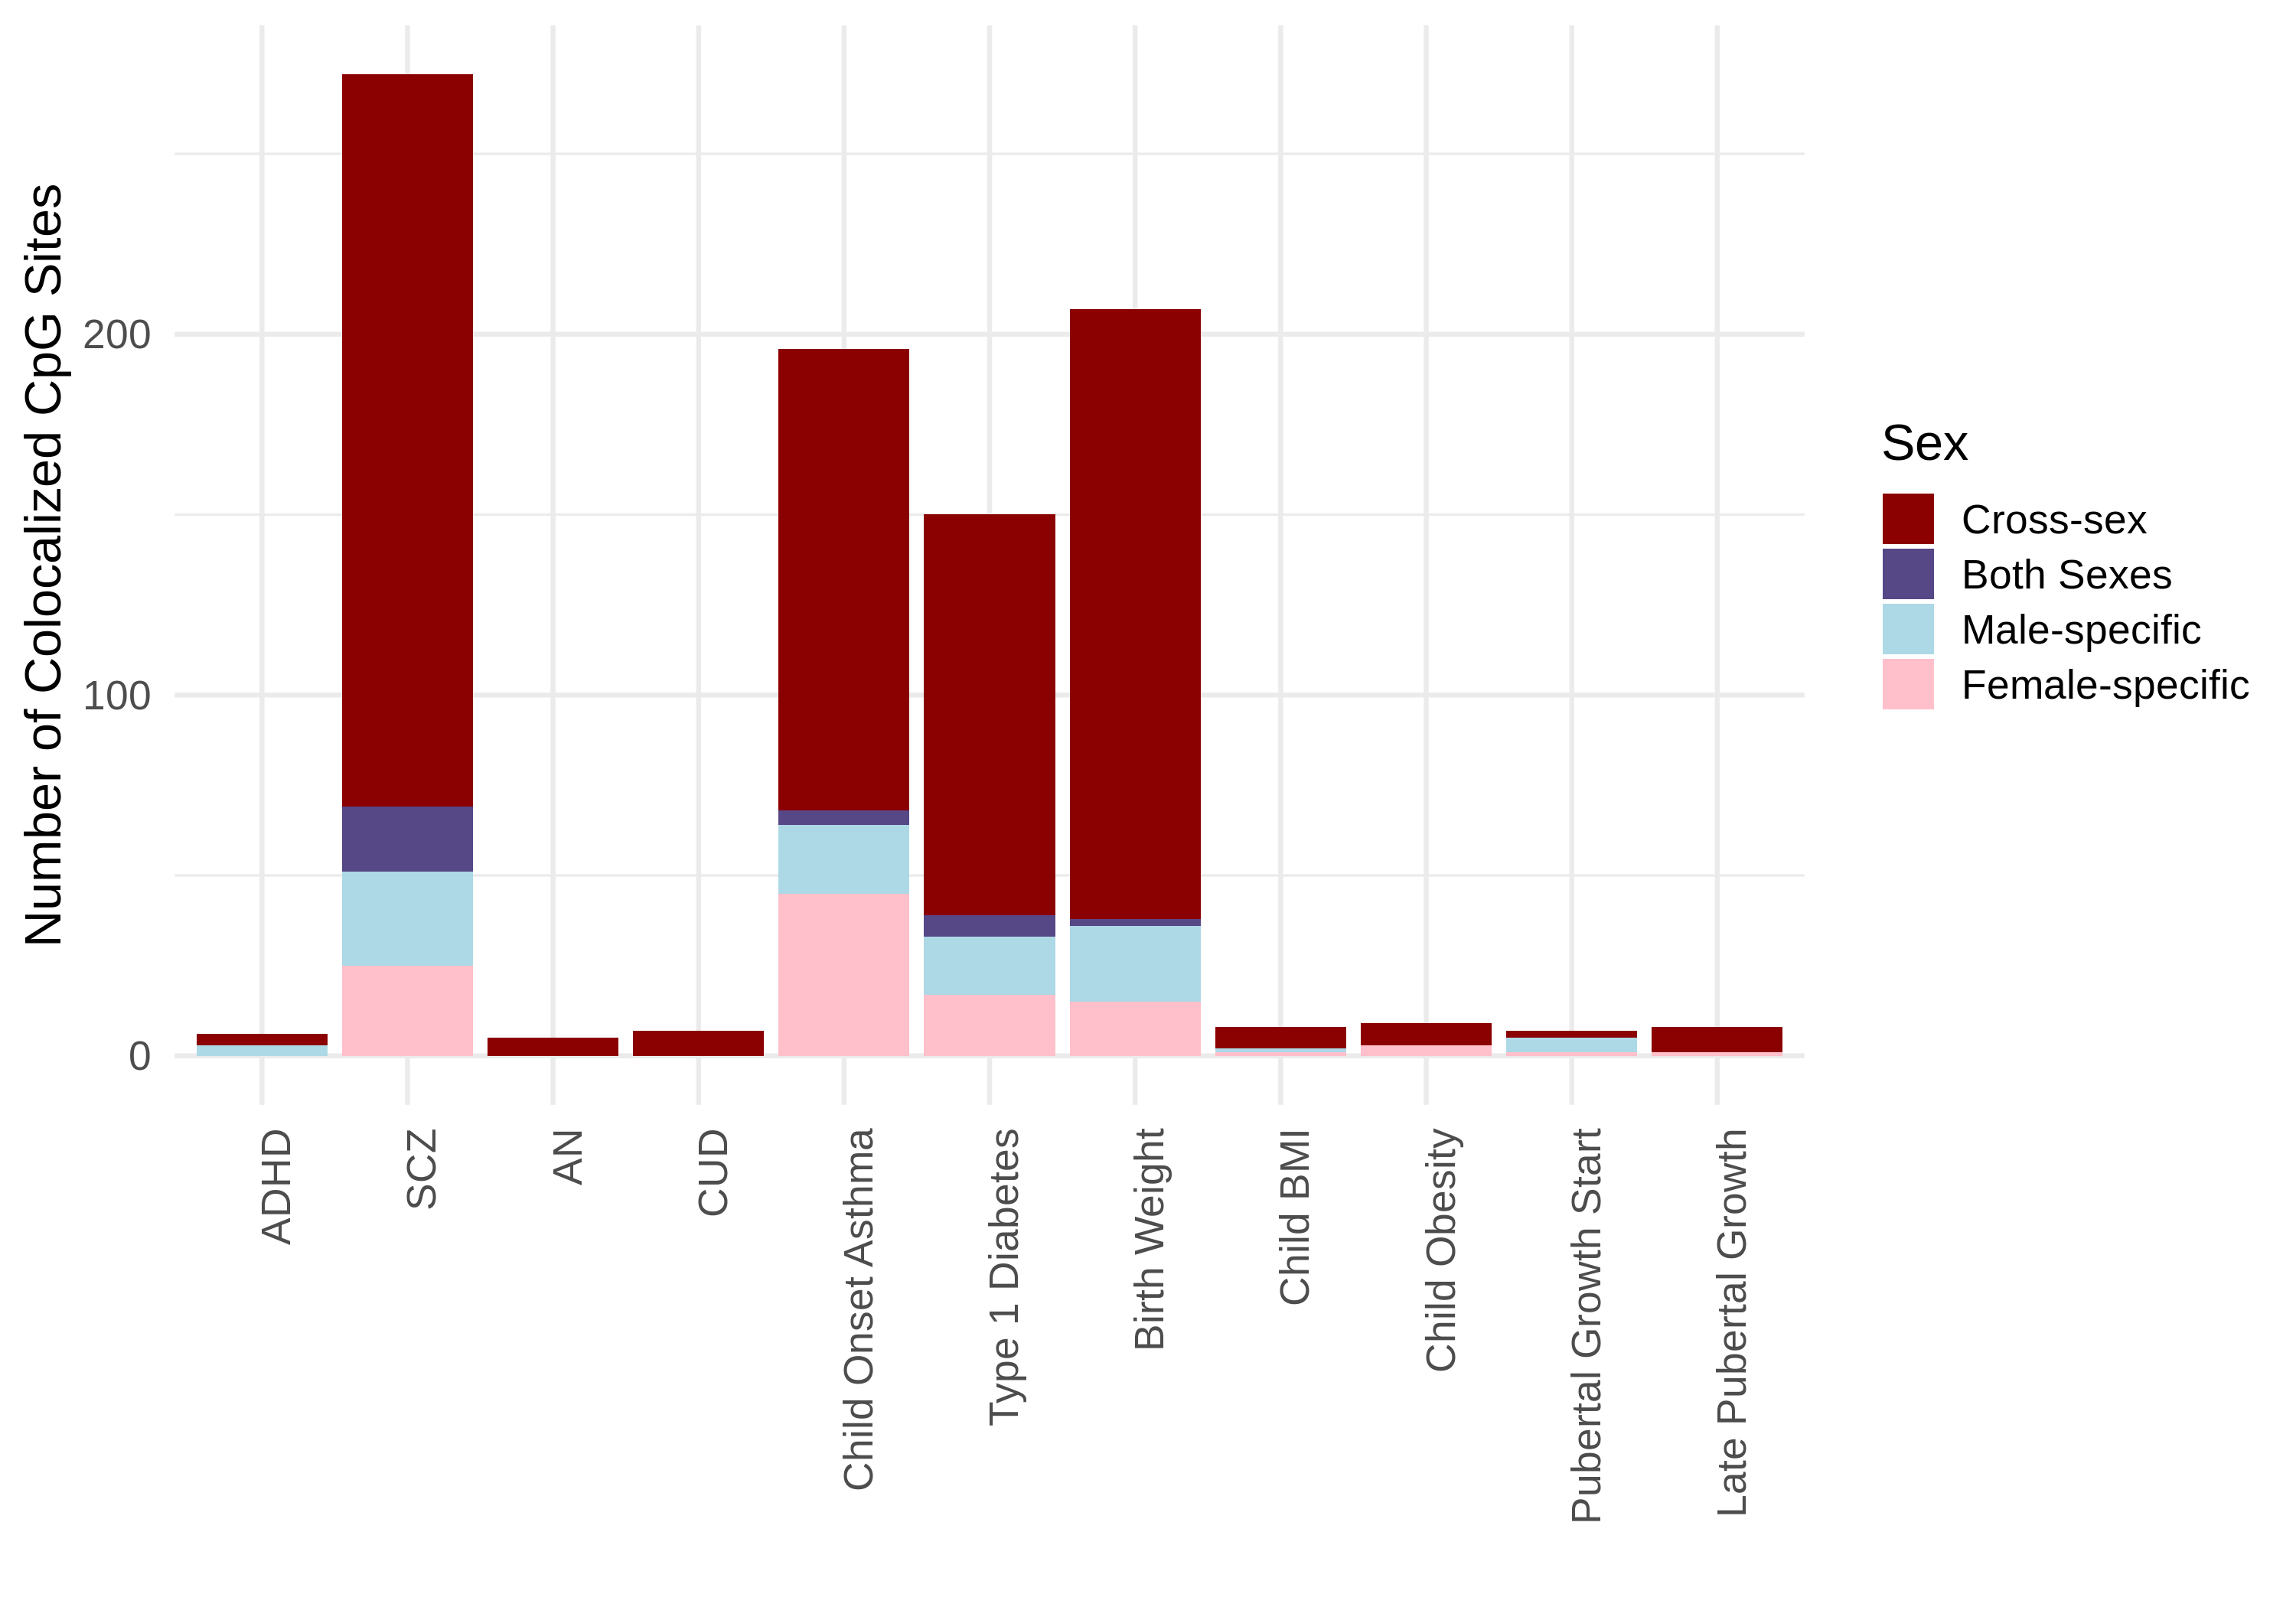

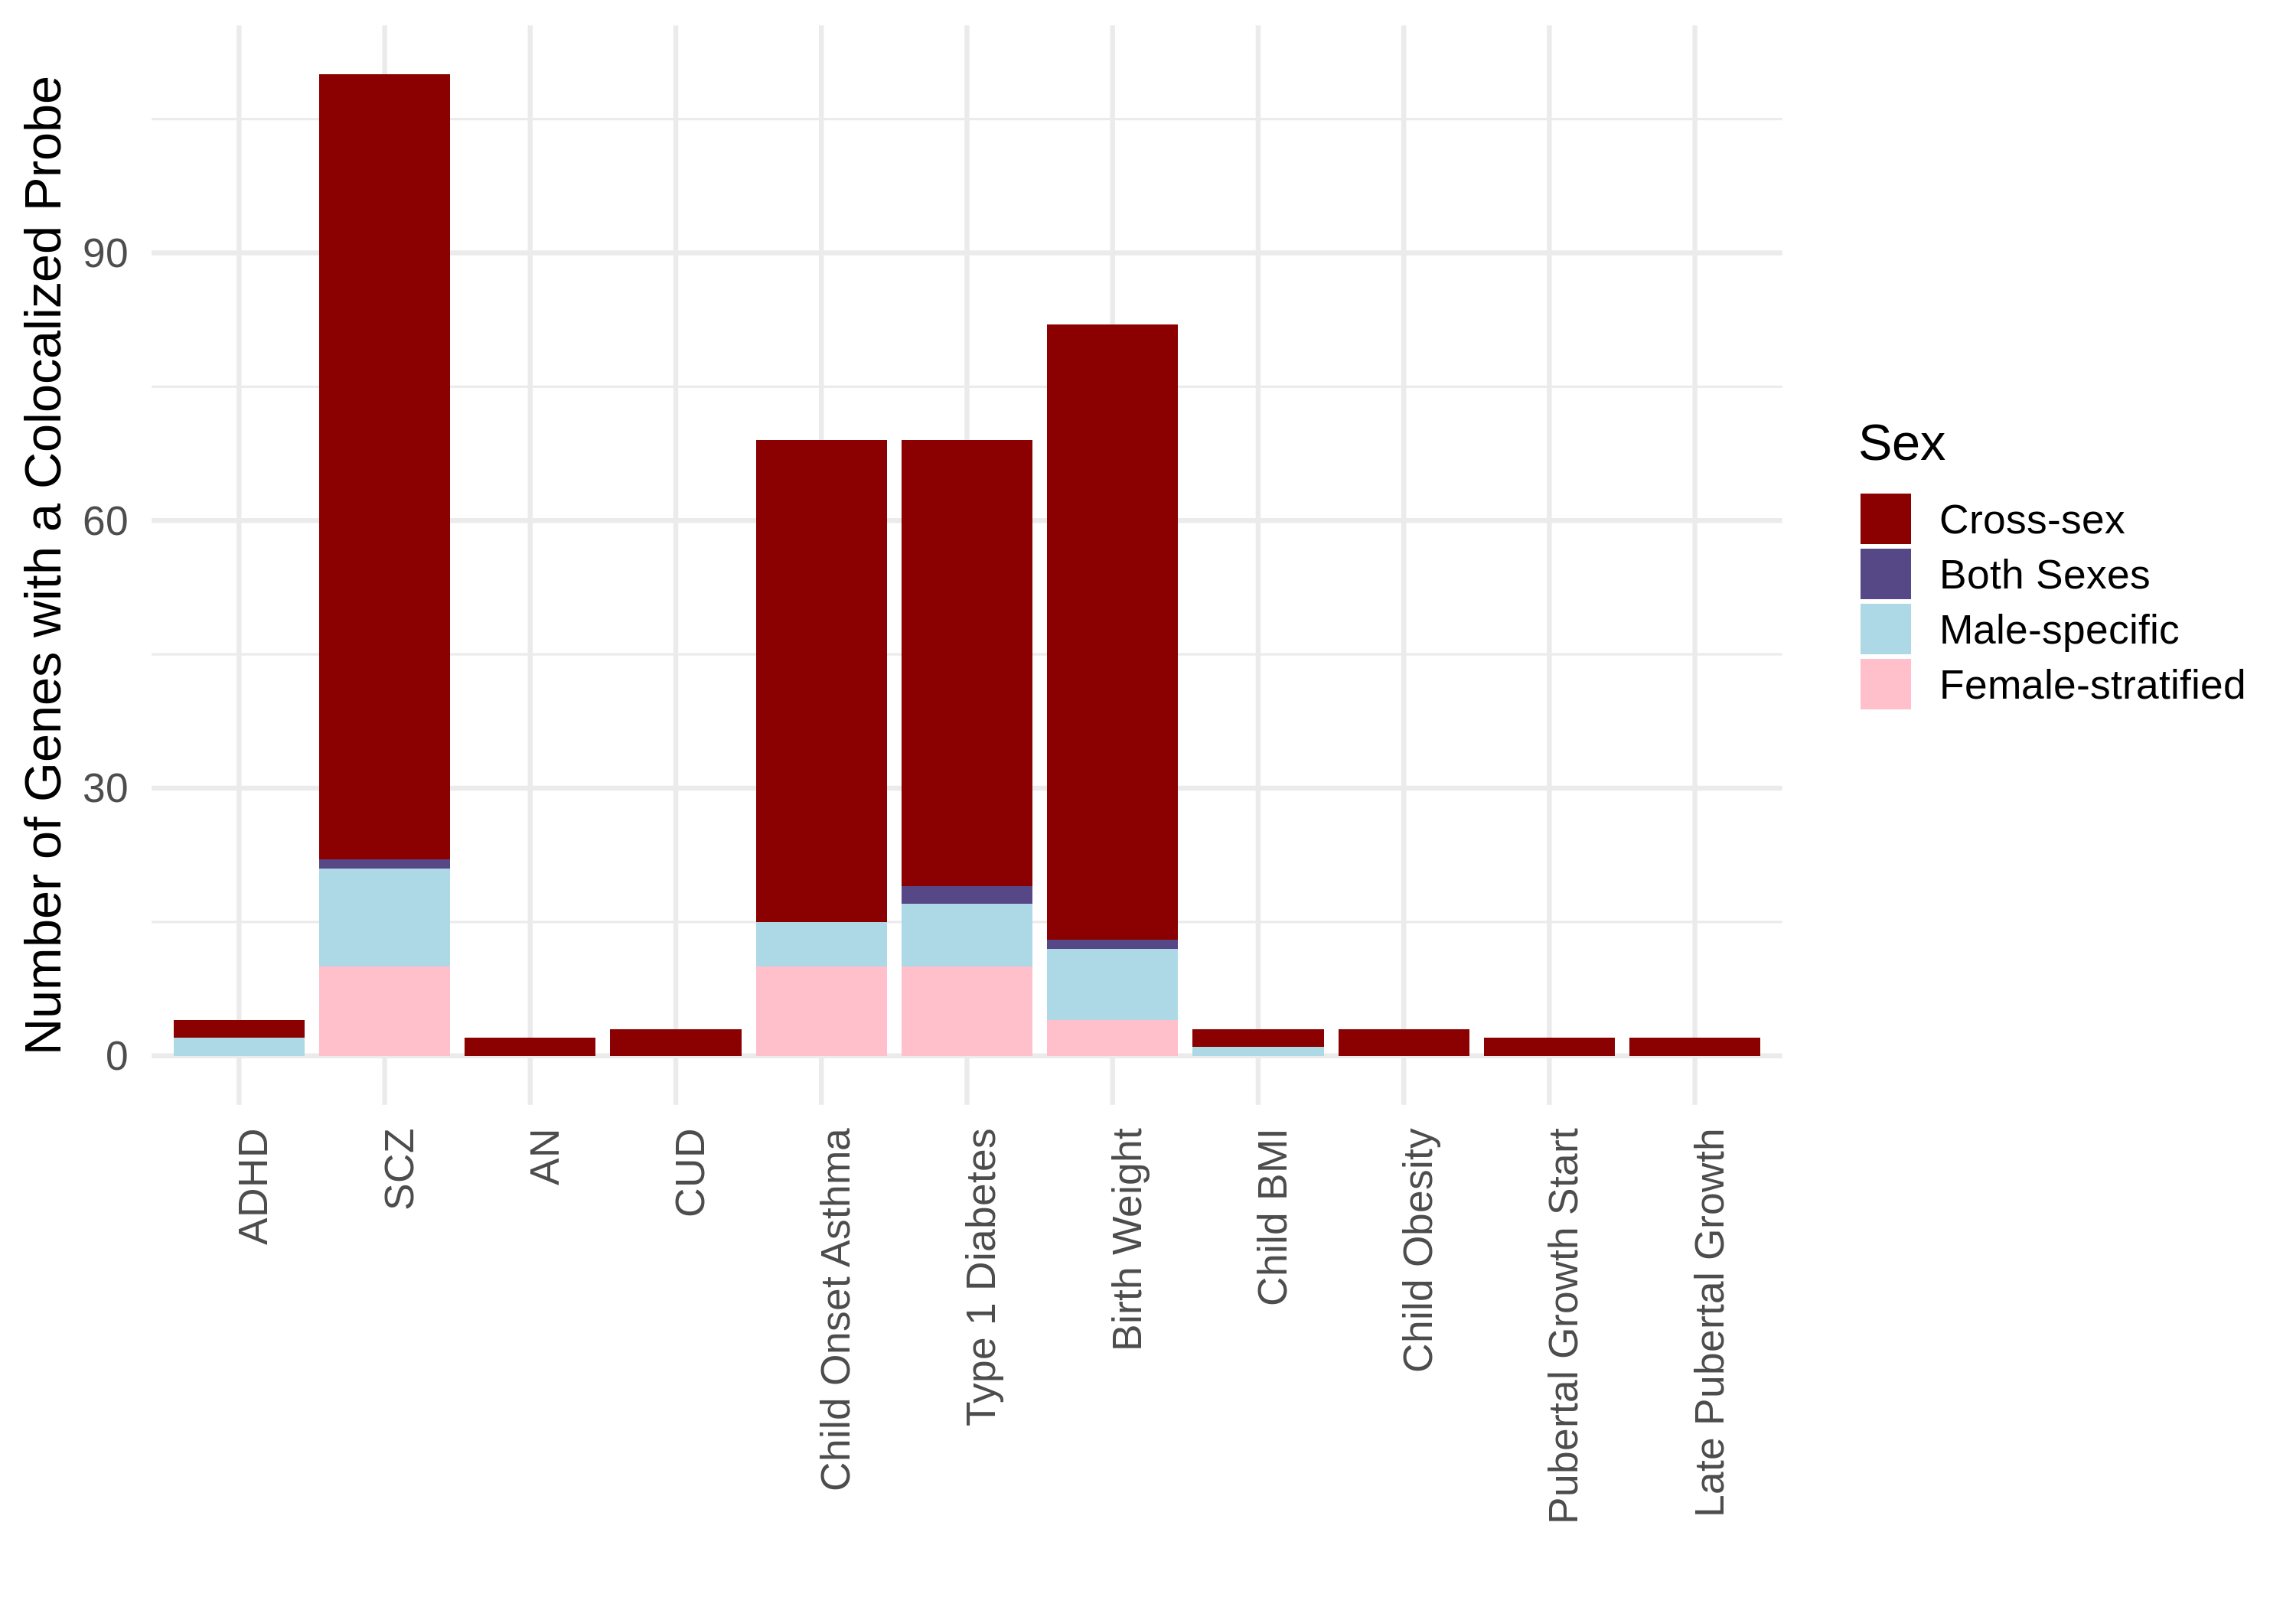

In [37]:
options(width=10,repr.plot.width= 10, repr.plot.height= 7, repr.plot.res = 300)

ggplot(
    colocalization_by_probe %>%
    mutate(Sex=replace(Sex,grepl("Cross-sex",Sex),"Cross-sex"),GWAS = factor(GWAS,levels=selected_traits))%>%
    mutate(Sex=recode_factor(Sex,"Cross-sex"="Cross-sex","Female-stratified,Male-stratified"="Both Sexes","Male-stratified"="Male-specific","Female-stratified"="Female-specific")),
    aes(GWAS,hits,fill=Sex)) +
    geom_col() +
    labs(y="Number of Colocalized CpG Sites",x="") +
    scale_fill_manual(values=c("dark red", "#564787","light blue", "pink"))+
    theme_minimal(base_size = 16)+
    theme(axis.text.x=element_text(angle=90,hjust=1,vjust=1))

ggplot(
    colocalization_by_gene %>%
    mutate(Sex=replace(Sex,grepl("Cross-sex",Sex),"Cross-sex"),GWAS = factor(GWAS,levels=selected_traits))%>%
    mutate(Sex=recode_factor(Sex,"Cross-sex"="Cross-sex","Female-stratified,Male-stratified"="Both Sexes","Male-stratified"="Male-specific","Female Stratified"="Female-specific")),
    aes(GWAS,hits,fill=Sex)) +
    geom_col() +
    labs(y="Number of Genes with a Colocalized Probe",x="") +
    scale_fill_manual(values=c("dark red","#564787","light blue", "pink"))+
    theme_minimal(base_size = 16)+
    theme(axis.text.x=element_text(angle=90,hjust=1,vjust=1))


In [38]:
colocalization_by_probe[!grepl("Cross-sex",Sex)][order(GWAS,Sex)]
colocalization_by_gene[!grepl("Cross-sex",Sex)][order(GWAS,Sex)]

colocalization_by_probe[grepl("Cross-sex",Sex)][order(GWAS,Sex)]
colocalization_by_gene[grepl("Cross-sex",Sex)][order(GWAS,Sex)]

Sex,GWAS,hits,probe
<chr>,<chr>,<int>,<chr>
Male-stratified,ADHD,3,"cg03504834,cg07166795,cg11409022"
Female-stratified,Birth Weight,15,"cg03303475,cg09199225,cg09523339,cg10090414,cg11040238,cg11982471,cg12101479,cg16037200,cg18050521,cg20217307,cg23524294,cg24648384,cg26135397,cg26197679,cg27619646"
"Female-stratified,Male-stratified",Birth Weight,2,"cg18795955,cg24859800"
Male-stratified,Birth Weight,21,"cg00733150,cg01453529,cg05008570,cg05469396,cg05986168,cg06418219,cg07613268,cg13463522,cg13684807,cg14331998,cg14700707,cg14862171,cg16448351,cg16706502,cg17114475,cg17182048,cg18694418,cg20763553,cg21238257,cg23203698,cg24251218"
Female-stratified,Child BMI,1,cg22071951
Male-stratified,Child BMI,1,cg09505516
Female-stratified,Child Obesity,3,"cg01884057,cg02353427,cg22071951"
Female-stratified,Child Onset Asthma,45,"cg00628211,cg00688979,cg01086672,cg01190171,cg01717973,cg01793865,cg02164110,cg02288747,cg02652369,cg02879159,cg03130962,cg04676934,cg04898211,cg05008570,cg05325934,cg05522349,cg06652085,cg06833981,cg07278158,cg08160477,cg09798996,cg11583907,cg11982471,cg12044213,cg12748446,cg15374898,cg16519772,cg17114475,cg17217478,cg20217307,cg20921096,cg21165793,cg21334609,cg21441945,cg21497082,cg21912938,cg22150763,cg22933800,cg24859800,cg25637655,cg26512045,cg26586118,cg27014438,cg27092297,cg27191651"
"Female-stratified,Male-stratified",Child Onset Asthma,4,"cg04917860,cg12564285,cg15498513,cg20356878"


Sex,GWAS,hits,gene
<chr>,<chr>,<int>,<chr>
Male-stratified,ADHD,2,"FOXP2,ST3GAL3"
Female-stratified,Birth Weight,4,"AGER,ZNF512B,PSORS1C3,HIST1H2BD"
"Female-stratified,Male-stratified",Birth Weight,1,ANK1
Male-stratified,Birth Weight,8,"SBF2,FURIN,SHC1,STMN3,C14orf126,HMGA2,TP53I3,KLHL29"
Male-stratified,Child BMI,1,ADCY3
Female-stratified,Child Onset Asthma,10,"OAZ3,JAZF1,BAT2,BAT1,NOTCH4,HLA-DRB6,HLA-DPB2,BAT3,HLA-DQA1,HLA-A"
Male-stratified,Child Onset Asthma,5,"C6orf10,AGER,TNXB,AGPAT1,NEU4"
Female-stratified,SCZ,10,"SCAND3,GABBR1,NEGR1,ARPC3,SATB2,MDC1,ALKBH6,C4B,ZBTB22,TEKT2"
"Female-stratified,Male-stratified",SCZ,1,SLC39A1


Sex,GWAS,hits,probe
<chr>,<chr>,<int>,<chr>
Cross-sex,ADHD,1,cg22797514
"Cross-sex,Female-stratified,Male-stratified",ADHD,1,cg03753284
"Cross-sex,Male-stratified",ADHD,1,cg11073811
Cross-sex,AN,3,"cg00383909,cg06216683,cg18651291"
"Cross-sex,Female-stratified,Male-stratified",AN,1,cg26102564
"Cross-sex,Male-stratified",AN,1,cg26528551
Cross-sex,Birth Weight,60,"cg00601727,cg00900524,cg01213447,cg01745499,cg02030452,cg03267442,cg04510874,cg04665046,cg04849508,cg05212570,cg05508408,cg06288089,cg06474225,cg06826457,cg07718650,cg07950252,cg08724371,cg09272948,cg09397246,cg10521431,cg11396628,cg11801110,cg12043019,cg12347123,cg13136596,cg13137809,cg13563462,cg13799504,cg13990743,cg14109847,cg14569352,cg15108060,cg16009970,cg16209860,cg16737517,cg16866941,cg17086139,cg18064631,cg18370025,cg18670767,cg18875496,cg19466160,cg19911850,cg20525461,cg21235334,cg21708867,cg22025263,cg22735105,cg23202253,cg23320056,cg23341612,cg23858360,cg24296920,cg25814743,cg25922125,cg26405020,cg26994657,cg27109043,cg27587826,ch.6.751103R"
"Cross-sex,Female-stratified",Birth Weight,10,"cg06366107,cg08377331,cg11953668,cg14863265,cg15358701,cg17908947,cg19470385,cg20068274,cg20732703,cg22158929"
"Cross-sex,Female-stratified,Male-stratified",Birth Weight,53,"cg00200653,cg00277334,cg00628211,cg00688979,cg00698126,cg01140214,cg02004401,cg02226672,cg02247838,cg02652369,cg03130962,cg03437748,cg04506342,cg04607235,cg04676934,cg05180856,cg05522349,cg05867245,cg06106103,cg06652085,cg06653140,cg07078329,cg07094194,cg07304760,cg07679836,cg07684647,cg07686394,cg07878625,cg09009770,cg09077675,cg09369927,cg09626299,cg10991855,cg11539674,cg11569329,cg11667387,cg12044213,cg12748446,cg13302670,cg14183927,cg14660024,cg15988812,cg16519772,cg17343385,cg20229609,cg21497082,cg23762465,cg24505687,cg25457927,cg25647583,cg26512045,cg26899598,cg27092297"


Sex,GWAS,hits,gene
<chr>,<chr>,<int>,<chr>
"Cross-sex,Female-stratified,Male-stratified",ADHD,1,C1orf84
"Cross-sex,Male-stratified",ADHD,1,PTPRF
Cross-sex,AN,1,WDR6
"Cross-sex,Female-stratified,Male-stratified",AN,1,MGMT
Cross-sex,Birth Weight,20,"PIM3,NR2F2,HMGA1,ALDH2,KCNQ1OT1,HTRA1,PSORS1C1,MIR600,GPSM1,RB1,YBX2,ARFRP1,DLG4,DNMT3B,ITPR2,ARHGEF2,HKDC1,ARMS2,GCC1,TBC1D12"
"Cross-sex,Female-stratified",Birth Weight,5,"ZBTB7B,FAM184B,SLC2A1,MAFF,C22orf26"
"Cross-sex,Female-stratified,Male-stratified",Birth Weight,28,"RORA,ZNF783,CCHCR1,SND1,GNA12,SMPD3,TCF19,IGF1R,BAZ2B,FES,APOLD1,ZBTB46,PDX1,SKP2,ADAM17,GRB10,BAK1,INTS7,WNT3A,TSPAN14,CNNM2,C6orf182,RPS9,CAMK2B,C17orf81,PEPD,DNAJC5,C6orf173"
"Cross-sex,Male-stratified",Birth Weight,16,"FAM118A,LIME1,AMZ1,PTH1R,DCUN1D2,NOTCH4,LOC731779,LHFPL2,PAX4,MSI2,MXI1,PRX,FKBP5,CLDN7,FCGR2C,DVL2"
Cross-sex,CUD,2,"SH2B1,ATXN2L"
